# Looking to analyze ripples during cat/FR when the same category is reinstated during encoding

In [110]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# sub lists I've been using to explore FR1 

subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
subs = ['R1461T']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
2151,NaN,protocols/r1/subjects/R1461T/experiments/catFR...,protocols/r1/subjects/R1461T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1461T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1461T/localizations/0/m...,NaN,0,R1461T,R1461T,3.4,protocols/r1/subjects/R1461T/experiments/catFR...
2152,NaN,protocols/r1/subjects/R1461T/experiments/catFR...,protocols/r1/subjects/R1461T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1461T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1461T/localizations/0/m...,NaN,1,R1461T,R1461T,3.4,protocols/r1/subjects/R1461T/experiments/catFR...


In [112]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[:50]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(568, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,NaN,protocols/r1/subjects/R1662S/experiments/catFR...,protocols/r1/subjects/R1662S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1662S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1662S/localizations/0/m...,NaN,7,R1662S,R1662S,3.4,protocols/r1/subjects/R1662S/experiments/catFR...
2846,NaN,protocols/r1/subjects/R1662S/experiments/catFR...,protocols/r1/subjects/R1662S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1662S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1662S/localizations/0/m...,NaN,8,R1662S,R1662S,3.4,protocols/r1/subjects/R1662S/experiments/catFR...
2851,NaN,protocols/r1/subjects/R1665J/experiments/catFR...,protocols/r1/subjects/R1665J/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1665J/localizations/0/m...,NaN,0,R1665J,R1665J,4.0,protocols/r1/subjects/R1665J/experiments/catFR...
2852,NaN,protocols/r1/subjects/R1665J/experiments/catFR...,protocols/r1/subjects/R1665J/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1665J/localizations/0/m...,NaN,1,R1665J,R1665J,4.0,protocols/r1/subjects/R1665J/experiments/catFR...


# Load CLUSTER data

In [125]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # nonHPC_MTL # ENTPHC
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []; category_array = [] # need these two to analyze categories during encoding

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []
semantic_clustering_key = []; temporal_clustering_key = []
session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp,selected_period)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment
            
        path_name = '/scratch/john/SWR_semantic_scratch/'+subfolder
#         path_name = '/scratch/john/SWR_semantic_scratch/ENCODING/2023-03-14_working_files_prior_to_adding_HFA_clustering'

        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            session_events = session_events.append(dat['session_events']) # doesn't append in place 
            
            # specific to whole_encoding
            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array']) # 1-indexed
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
#             channel_nums.extend(dat['channel_nums']) # no channel_nums in Clustering code for whatever reason
            list_num_key.extend(dat['list_num_key'])
            if exp == 'catFR1':
                category_array.extend(dat['category_array'])
                semantic_clustering_key.extend(dat['semantic_clustering_key'])
            elif exp == 'FR1':
                temporal_clustering_key.extend(dat['temporal_clustering_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords)

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.extend(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# serialpos too!
sp_array = []
for sp in serialpos_array:
    sp_array.extend(sp)
serialpos_array = sp_array

# this is same as word_correct_array just 0/1/2 instead of 0/1s
temp = []
for enc in encoded_word_key_array:
    temp.extend(enc)
encoded_word_key_array = copy(temp)


# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

[]
[]
2023-03-23_17-19-52: DF Exception: Sub: R1004D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1004D_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-125-d6108471008c>, line no: 55
2023-03-23_17-19-55: DF Exception: Sub: R1067P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1067P_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-125-d6108471008c>, line no: 55
2023-03-23_17-19-55: DF Exception: Sub: R1086M, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1086M_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-125-d6108471008c>, line no: 55
2023-03-23_17-20-02: DF Exception: Sub: R1147P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1147P_0_HPC_encoding_soz_in_hamming.p'

(241894, 1500)

From 243/259 sessions with >0 HPC electrodes
Total trials: 241894
Unique sessions: 243
...from 122 patients
Number of electrodes: 594
Electrode regions X sessions:
218 for  left hippocampus
180 for  right hippocampus
277 for "ca1"
140 for "dg"
34 for "sub"
114 for left ca1
3 for left ca2
3 for left ca3
73 for left dg
266 for left hippocampus
30 for left sub
105 for right ca1
42 for right dg
187 for right hippocampus
17 for right sub


In [89]:
# to get total patient count including all regions
# HPC_subs = np.unique(subject_name_array)
# nonHPC_subs = np.unique(subject_name_array)
# test = np.append(HPC_subs,nonHPC_subs)
np.unique(test)
# len(np.unique(test))
# total patients is 129
# HPC is 252 sessions from 126 patients (checked and amazingly only 3 without HPC...catFR mostly sEEG I suppose)
# nonHPC_MTL is 191 sessions from 95 patients

len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(semantic_clustering_key)
len(category_array)
len(temporal_clustering_key)
len(session_name_array)

array([<numpy._pytesttester.PytestTester object at 0x2af176be2f90>],
      dtype=object)

38304

38304

38304

38304

38304

38304

38304

38304

38304

0

38304

In [ ]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
if selected_period == 'whole_encoding':
    xticks(range(0,20000,2500),range(0,40000,5000))
    plot([1000,1000],[0,0.015])    
elif selected_period == 'encoding':
    xticks(ticks=range(-350,1501,100),labels=range(-1400,3001,200),rotation=60)
    plot([350,350],[0,0.015])
    plot([1150,1150],[0,0.015])   
elif selected_period == 'whole_retrieval':
    xticks(ticks=range(0,17001,2500),labels=range(0,32001,5000),rotation=60)
    plot([1000,1000],[0,0.015]) 
    plot([1000+15000,1000+15000],[0,0.015]) 
# ylim(0,0.015)
title(exp)
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

# Get start_array and select subfield if HPC for free recalls

In [126]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #['ca1','dg'] #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
# print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif ( (type(select_lists_with_recalls) == list) | (isinstance(select_lists_with_recalls, np.ndarray)) ):    
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# these lists did not have 12 word presentations, so remove them
if exp == 'catFR1':
    updated_recalls[(np.array(session_name_array)=='R1180C-2') & (np.array(list_num_key)==24)] = 0
    updated_recalls[(np.array(session_name_array)=='R1278E-10') & (np.array(list_num_key)==25)] = 0
    
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
# channel_nums_array = np.array(channel_nums_array)[updated_recalls]

# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
# specific to whole_encoding
# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
session_events = session_events[updated_recalls]

if exp == 'catFR1':   
    category_array = np.array(category_array)[updated_recalls]
    semantic_clustering_key = np.array(semantic_clustering_key)[updated_recalls]
elif exp == 'FR1':
    temporal_clustering_key = np.array(temporal_clustering_key)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 1291
from 243 sessions from 122 subjects with trial nums:
[120. 120. 120. 120. 120. 120. 120. 300. 300. 156. 156. 156. 156. 156.
 156. 156. 156. 216. 216. 216.]
Trial sum = 241894.0
Number of sub_sess names: 1291
Got encoding start_array!
Got start_array with 97872 trials!
Number of electrodes: 227
...from 86 patients
# of trials: 97872
Total # of ripples: 95164
Overall ripple rate: 0.324 Hz


In [99]:
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(semantic_clustering_key)
len(category_array)
len(temporal_clustering_key)
len(session_name_array)

38304

38304

38304

38304

38304

38304

38304

38304

38304

0

38304

## Subject-level memory performance

In [72]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

ripple_bin_start_end = [100,1700]
min_trials = 20 # define up here since use for ME model arrays being appended too

psth_start = -700 # setting in SWRanalysis for pre_encoding_time

import statsmodels.formula.api as smf
import warnings
%autoreload

sub_Ts1 = []
sub_Bs1 = [] 
sub_delta1 = [] # change in ripple rate for recalled - not recalled

# for mixed model of correlations get session-level ripples and accuracy
sess_sessions = []
sess_delta = []
sess_subjects = []
sess_recall_num = []

trial_accum = []; trial_accum_correct = []
sub_z_score = []
rate_accum = []; rate_accum_correct = []; rate_accum_wrong = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

# all these ME variables are at trial-level
ME_bin = []; ME_subject_recall_num = []
ME_sessions = []; ME_subjects = []
ME_list_level_correct = []; ME_correct = []
ME_delta = []


for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]        
        sub_electrode_array = electrode_array[sub_idxs]
        sub_recall_position_array = recall_position_array[sub_idxs]
        sub_word_correct_array = word_correct_array[sub_idxs]        
        sub_list_num_key = list_num_key[sub_idxs]
        sub_semantic_clustering_key = semantic_clustering_key[sub_idxs]
       
        # now get z-score separately for each sub with ME model

        # measure significance from 
        stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding        

        binned_stats_array = sub_start_array[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_array = binBinaryArray(binned_stats_array,stats_bin,sr_factor)
        
        if len(binned_stats_array) >= min_trials:
            
            # what is this patient's average accuracy?
            session_avg_corr = []
            for i_sess,sess in enumerate(np.unique(sub_session_name_array)):
                
                # take single elec from every session so don't double count sessions

                first_elec = np.unique(sub_electrode_array[sub_session_name_array==sess])[0]
                
                session_recalls = sub_recall_position_array[((sub_session_name_array==sess) & \
                                                         (sub_electrode_array==first_elec))]# this is a list of lists for accuracy in this session
                sub_list_level_recalls = [len(np.unique(np.array(x)[np.array(x)>0])) for x in session_recalls]
                if len(sub_list_level_recalls)==0:
                    print('First session does not have first electrode for '+sess)
                session_avg_corr.append(np.nanmean(sub_list_level_recalls)) # mean correct for this session (lists always same length so can just avg)
                
                # but to know list-level accuracy for each trial we need to do this for every electrode
                for elec in np.unique(sub_electrode_array):
                    session_recalls = sub_recall_position_array[((sub_session_name_array==sess) & \
                                                                 (sub_electrode_array==elec))]
                    ME_list_level_correct.extend([len(np.unique(np.array(x)[np.array(x)>0])) for x in session_recalls])
                    
                # session-level info for ME model across subs
                sess_subjects.append(sub)
                sess_sessions.append(sess)
                sess_recall_num.append(np.nanmean(sub_list_level_recalls))
                # session-level ripple delta
                sess_delta.append(np.mean(binned_stats_array[((sub_session_name_array==sess) & (sub_word_correct_array==1))]) - 
                                np.mean(binned_stats_array[((sub_session_name_array==sess) & (sub_word_correct_array==0))]))
                    

            sub_avg_recall_num.append(np.nanmean(session_avg_corr)) # average over sessions for final accuracy value
            temp_sub_names.append(sub)

            rate_accum.append(np.mean(binned_stats_array))
            rate_accum_correct.append(np.mean(binned_stats_array[sub_word_correct_array==1]))
            rate_accum_wrong.append(np.mean(binned_stats_array[sub_word_correct_array==0]))            
            trial_accum.append(len(binned_stats_array))
            trial_accum_correct.append(sum(sub_word_correct_array))
            trial_ct+=len(binned_stats_array)
            

            

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_stats_array)
                print(str(np.mean(binned_stats_array))+' for '+str(len(binned_stats_array))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model (all of these are at trial-level)

            ME_bin.extend([r[0] for r in binned_stats_array]) # need to unpack each array
            ME_subject_recall_num.extend(sub_avg_recall_num[-1]*np.ones(len(binned_stats_array)))
            ME_correct.extend(sub_word_correct_array)
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)
            ME_delta.extend( (rate_accum_correct[-1]-rate_accum_wrong[-1]) * np.ones(len(binned_stats_array)) ) 

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                
                # model for each sub to assess significance of SME
                sub_SME_df = pd.DataFrame(data={'session':sub_session_name_array,'subject':sub_subject_name_array,
                               'correct':sub_word_correct_array,'ripple_rates':binned_stats_array[:,0]})
                vc = {'session':'0+session'}
                sig_bin_model = smf.mixedlm("ripple_rates ~ correct", sub_SME_df, groups="subject", vc_formula=vc,re_formula='correct')
                bin_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)

                sub_Ts1.append(bin_model.tvalues[1])
                sub_Bs1.append(bin_model.params[1])
                
# corrected_for_nans = 0 # for below
a=1;

done binning start_arrays (printing every 10th)
0.20555555555555555 for 900 trials
18600
done binning start_arrays (printing every 10th)
0.234375 for 192 trials
36444
done binning start_arrays (printing every 10th)
0.16145833333333334 for 600 trials
42156
done binning start_arrays (printing every 10th)
0.42291666666666666 for 1500 trials
50112
done binning start_arrays (printing every 10th)
0.350068306010929 for 732 trials
58440
done binning start_arrays (printing every 10th)
0.25390625 for 288 trials
64068
done binning start_arrays (printing every 10th)
0.3385416666666667 for 144 trials
67392
done binning start_arrays (printing every 10th)
0.2907986111111111 for 288 trials
84024


In [73]:
# run this to select good subs for figures below (can only run once after load since it replaces variables)

save_figs = 0

import seaborn as sb
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
    
min_correct_trials = 50

# only keep subs with sufficient trials and ripple rates
good_subs = ((np.array(trial_accum_correct)>=min_correct_trials)&(np.array(rate_accum) > min_rate))
rate_accum = np.array(rate_accum)[good_subs]  
rate_accum_correct = np.array(rate_accum_correct)[good_subs]
rate_accum_wrong = np.array(rate_accum_wrong)[good_subs]
sub_Ts1 = np.array(sub_Ts1)[good_subs]    
trial_accum = np.array(trial_accum)[good_subs]    
temp_sub_names = np.array(temp_sub_names)[good_subs]        
sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]  

Mixed model of ripple_rate ~ avg_recall_num
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ripple_rate
No. Observations:     97872       Method:                 REML       
No. Groups:           86          Scale:                  0.2849     
Min. group size:      144         Likelihood:             -77661.5694
Max. group size:      10500       Converged:              Yes        
Mean group size:      1138.0                                         
---------------------------------------------------------------------
                             Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                    0.259    0.036 7.239 0.000  0.189  0.330
avg_recall_num               0.014    0.009 1.550 0.121 -0.004  0.031
subject Var                  0.010    0.042                          
subject x avg_recall_num Cov 0.000    0.012                   

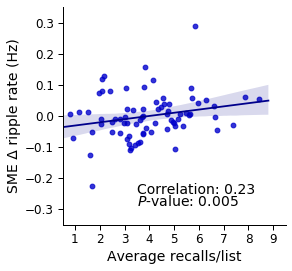

Max is 0.4, Min is -0.32
Number of low recall patients: 38
Number of high recall patients: 39
T-test between these: p = 0.005058426047839527
T-test between t-stats for each group instead: p = 0.00466993968320055
t-statistic: 2.916273484637261


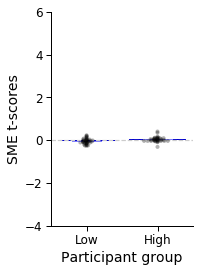

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max is 0.4, Min is -0.32


TypeError: 'float' object is not callable

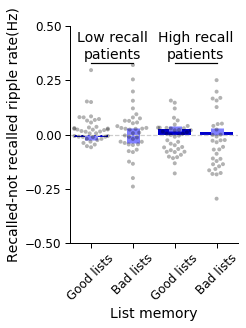

In [74]:

### $$$# subject-level figures we decided on ##$$###$

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # mixed model of correlation below
    ME_df = pd.DataFrame({'ripple_rate':ME_bin,'avg_recall_num':ME_subject_recall_num,'delta_ripple_rate':ME_delta,
                            'session':ME_sessions,'subject':ME_subjects,'correct':ME_correct})      
    
    print('Mixed model of ripple_rate ~ avg_recall_num')
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("ripple_rate ~ avg_recall_num", ME_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
    bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
    print(bin_model1.summary())

    sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                            'session':sess_sessions,'subject':sess_subjects})
    print('Mixed model of ripple_rate ~ avg_recall_num at session-level')         
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num", sess_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
    bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
    print(bin_model1.summary())
    
    
## Ripple rate delta v. recall num ##

rate_accum_delta = np.array(rate_accum_correct) - np.array(rate_accum_wrong)

set_pubfig()
deltaRR_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum_delta,
                        'sub_Ts1':sub_Ts1})
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='avg_recall_num',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
    xticks(np.arange(1,7.5+0.01,1))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.5,9.5))
    xticks(np.arange(1,9.5+0.01,1))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_avg_recall_num,rate_accum_delta)

annotate('Correlation: '+str(np.round(plot_corr[0],3)),(3.5,-0.25)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1]
                                   ,3)),(3.5,-0.29))

ylabel(u'SME Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
# title('Encoding ripple rise v. accuracy ('+location_selected.upper()+')')

if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/deltaRRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
show()


## high v. low recall patients ##

split_into = 2 # high v. low
delta_ripple_or_Ts = 1 # 0 for delta_ripples; 1 for sub_Ts

set_pubfig()
deltaRR_df = copy(deltaRR_df) # deltaRR_df is delta(rate) 
quartile_labels = range(split_into)
quartiles = pd.qcut(deltaRR_df.avg_recall_num,split_into,labels=quartile_labels)
quartile_idxs = np.array(quartiles.values)
mean_ripples = []; ste_ripples = []
mean_mem = []; ste_mem = []
for val in np.unique(quartile_idxs):
    selected_quartile = quartile_idxs==val
    if delta_ripple_or_Ts == 0:
        mean_ripples.append(np.mean(deltaRR_df.ripple_rates[selected_quartile]))
        ste_ripples.append(np.std(deltaRR_df.ripple_rates[selected_quartile])/np.sqrt(len(deltaRR_df.ripple_rates[selected_quartile])))
    else:
        mean_ripples.append(np.mean(deltaRR_df.sub_Ts1[selected_quartile]))
        ste_ripples.append(np.std(deltaRR_df.sub_Ts1[selected_quartile])/np.sqrt(len(deltaRR_df.sub_Ts1[selected_quartile])))        
deltaRR_df['idxs'] = quartile_idxs # for swarmplot

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))
gca().axhline(0, ls='--',color=(0.8,0.8,0.8))

gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    if delta_ripple_or_Ts == 0:
        sb.swarmplot(x='idxs',y='ripple_rates',data=deltaRR_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-0.5,0.5))
        ytick_range = np.arange(-0.5,0.501,0.25)
        ylabel(u'Δ ripple rate (Hz)')
    else:
        sb.swarmplot(x='idxs',y='sub_Ts1',data=deltaRR_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-4,6))
        ytick_range = np.arange(-4,6.01,2)        
        ylabel(u'SME t-scores')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([0,1],['Low','High'],fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')
print('Max is '+str(np.round(max(deltaRR_df.sub_Ts1),2))+', Min is '+str(np.round(min(deltaRR_df.sub_Ts1),2)))



print('Number of low recall patients: '+str(sum(np.array(quartiles.values))))
print('Number of high recall patients: '+str(sum(np.array(quartiles.values)==0)))
print('T-test between these: p = '+
    str(ttest_ind(deltaRR_df.ripple_rates[np.array(quartiles.values)==1], deltaRR_df.ripple_rates[np.array(quartiles.values)==0])[1]))
print('T-test between t-stats for each group instead: p = '+
    str(ttest_ind(deltaRR_df.sub_Ts1[np.array(quartiles.values)==1], deltaRR_df.sub_Ts1[np.array(quartiles.values)==0])[1]))
print('t-statistic: '+str(ttest_ind(deltaRR_df.sub_Ts1[np.array(quartiles.values)==1], deltaRR_df.sub_Ts1[np.array(quartiles.values)==0])[0]))
np.mean(deltaRR_df.ripple_rates[np.array(quartiles.values)==1]) # high ripple rate patients
np.mean(deltaRR_df.ripple_rates[np.array(quartiles.values)==0])
np.mean(deltaRR_df.avg_recall_num[np.array(quartiles.values)==1]) # high memory patients
np.mean(deltaRR_df.avg_recall_num[np.array(quartiles.values)==0])

tight_layout()
if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/low_v_high_memory_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+filter_type+'_'+sub_selection+extra+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()



## high v. low lists for each patient: ##


# only use subjects that passed minimum trial threshold
good_sub_high_lists = []
good_sub_low_lists = []
bad_sub_high_lists = []
bad_sub_low_lists = []
for i_sub,sub in enumerate(temp_sub_names):
    
    # get median value for accuracy of lists for this sub
    sub_list_level_correct = np.array(ME_list_level_correct)[np.array(ME_subjects)==sub]
    median_list_accuracy = np.median(np.array(ME_list_level_correct)[np.array(ME_subjects)==sub]) # at trial-level can best split using median
    
    # quartiles has the split of good v. bad memory subjects using same "good_subs" as avg_recall_num
    if quartiles.values[i_sub]==0: # bottom half memory sub
        bad_sub_high_lists.append(np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==1) & \
                                                              (np.array(ME_list_level_correct)>=median_list_accuracy)) ]) - \
                                  np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==0) & \
                                                              (np.array(ME_list_level_correct)>=median_list_accuracy)) ])
                                 )
        bad_sub_low_lists.append(np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==1) & \
                                                             (np.array(ME_list_level_correct)<median_list_accuracy)) ]) - \
                                  np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==0) & \
                                                              (np.array(ME_list_level_correct)<median_list_accuracy)) ])
                                )
    else: # top half memory sub
        good_sub_high_lists.append(np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==1) & \
                                                              (np.array(ME_list_level_correct)>=median_list_accuracy)) ]) - \
                                  np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==0) & \
                                                              (np.array(ME_list_level_correct)>=median_list_accuracy)) ])                                  
                                  )
        good_sub_low_lists.append(np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==1) & \
                                                             (np.array(ME_list_level_correct)<median_list_accuracy)) ]) - \
                                  np.mean(np.array(ME_bin)[ ((np.array(ME_subjects)==sub) & (np.array(ME_correct)==0) & \
                                                              (np.array(ME_list_level_correct)<median_list_accuracy)) ])
                                 )

figSub,axSub = plt.subplots(1,1, figsize=(3,4))

mean_diffs = [np.mean(bad_sub_high_lists),np.nanmean(bad_sub_low_lists),np.mean(good_sub_high_lists),np.mean(good_sub_low_lists)]
mean_ste = [np.std(bad_sub_high_lists)/np.sqrt(len(bad_sub_high_lists)),np.nanstd(bad_sub_low_lists)/np.sqrt(len(bad_sub_low_lists)),
            np.std(good_sub_high_lists)/np.sqrt(len(good_sub_high_lists)),np.std(good_sub_low_lists)/np.sqrt(len(good_sub_low_lists))]
diff_df = pd.DataFrame({'mean_diffs':good_sub_high_lists+good_sub_low_lists+bad_sub_high_lists+bad_sub_low_lists,
                        'group_indicator':np.concatenate((np.zeros(len(good_sub_high_lists)),np.ones(len(good_sub_low_lists)), \
                                          2*np.ones(len(bad_sub_high_lists)),3*np.ones(len(bad_sub_low_lists))))
                       })

bar(range(4),mean_diffs,yerr=mean_ste,color=plot_color,error_kw=dict(lw=13, capsize=0, capthick=0, ecolor=errorbar_color))
gca().axhline(0, ls='--',color=(0.8,0.8,0.8))

gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    sb.swarmplot(x='group_indicator',y='mean_diffs',data=diff_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
    axSub.set(ylim=(-0.5,0.5))
    ytick_range = np.arange(-0.5,0.501,0.25)
    ylabel('Recalled-not recalled ripple rate(Hz)')
    
yticks(ytick_range,fontsize=12)
xticks(range(4),['Good lists','Bad lists','Good lists','Bad lists'],fontsize=12,rotation=45) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('List memory')
print('Max is '+str(np.round(max(deltaRR_df.sub_Ts1),2))+', Min is '+str(np.round(min(deltaRR_df.sub_Ts1),2)))
plot([0,1],[0.33,0.33],'k'); text(0.5,0.35,'Low recall\npatients',horizontalalignment='center')
plot([2,3],[0.33,0.33],'k'); text(2.5,0.35,'High recall\npatients',horizontalalignment='center')
ylim(-0.35,0.35)
a=1;



## t-score histogram (PRE) ##

# (doing this at end since I ensure PRE bin and bin 1 sec earlier have > 0.1 hz RRs) 

set_pubfig()
sub_Ts_df = pd.DataFrame({'sub_Ts':sub_Ts1,'ripple_delta':rate_accum_delta})
if region_name == 'HPC':
    fig, ax = subplots(figsize=(3,4))
else:
    fig, ax = subplots(figsize=(3,3))

# first plot the error bars
st_err = np.std(sub_Ts1)/np.sqrt(len(sub_Ts1))
bar_bottom = np.mean(sub_Ts1)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=sub_Ts_df, palette=plot_color) 
# ax1 = p1.axes
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
if region_name == 'HPC':
    if selected_period == 'surrounding_recall':
        ax.set(ylim=(-3.25,6.25))
    else:
        ax.set(ylim=(-4,6))
        ytick_range = np.arange(-4,6.01,2)
else:
    ax.set(ylim=(-3.25,4.25))
yticks(ytick_range,fontsize=12)
ylabel('SME t-scores')
tight_layout()
print('Number of participants in plot: '+str(len(sub_Ts1)))

if save_figs == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_figs = 0
show()
# print sign test across subjects too
test_sub_Ts1 = sub_Ts1[~isNaN(sub_Ts1)]
t_stat,onesample_p = stats.ttest_1samp(test_sub_Ts1,0)
print('One-sample t-test of t-scores: '+str(onesample_p))
print('t-statistic: '+str(t_stat))


## delta ripple rate ##

set_pubfig()
fig, ax = subplots(figsize=(3,4))

# first plot the error bars
st_err = np.std(rate_accum_delta)/np.sqrt(len(rate_accum_delta))
bar_bottom = np.mean(rate_accum_delta)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='ripple_delta', data=sub_Ts_df, palette=plot_color) 
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
ax.set(ylim=(-0.25,0.25))

ylabel('Correct - wrong ripples rate')
tight_layout()
print('Number of participants in plot: '+str(len(rate_accum_delta)))


##$$$ ###

a=1;

# SCE (Subsequent Clustering Effect?)

## temporal clustering for FR

In [101]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors

adj_temporal_encoding_array = []
rem_temporal_encoding_array = []
chaining_encoding_array = [] # -995 is code I used for recalls where people start at 1 and go 1->2->3->etc.
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
forgot_encoding_array = []
sub_name_array0 = []; sess_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []
sub_name_array5 = []; sess_name_array5 = [] # forgotten

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_temporal_key = temporal_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]

            for i_recall_type,recall_type in enumerate(list_ch_temporal_key[0]): # all 12 words have same values so just take 1st one
                
                recall_position = list_ch_recall_positions[0][i_recall_type]
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    if ((np.abs(recall_type) == 1)): # or (recall_type == -995)): # can change this to adjacent temporal including chaining
                        # note the -1 since recall positions are on scale of 1-12
                        adj_temporal_encoding_array = superVstack(adj_temporal_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                    elif ( (np.abs(recall_type) >= 4) & (np.abs(recall_type)<12) ): # remote temporal; ≥4 matches adjacent temporal better
                        rem_temporal_encoding_array = superVstack(rem_temporal_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                    elif recall_type == -995: # chaining only
                        chaining_encoding_array = superVstack(chaining_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)                    
                    elif i_recall_type==(len(list_ch_temporal_key[0])-1): # last word of list (I checked it's always a 0 so can ignore recall_type)
                        last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        
            # get not recalled arrays too
            forgotten_words = 1-np.array(list_ch_corr)
            if sum(forgotten_words)>0: # R1065 a whiz
                forgot_encoding_array = superVstack(forgot_encoding_array,np.array(list_ch_encoding_array)[findInd(forgotten_words),:])
                sub_name_array5.extend(np.tile(sess[0:6],int(sum(forgotten_words))))
                sess_name_array5.extend(np.tile(sess,int(sum(forgotten_words))))
            test=1

done making binned start_array with shape:
(7319, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SEs created!
done making binned start_array with shape:
(83950, 26)
SEs created!


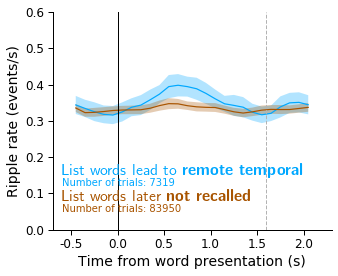

In [102]:
save_fig = 0
plot_SE = 1

# get PSTH for two of the types
plot_two = [1,5]  # [1,3] # [2,0] # [0,3]
# 0 is adjacent_temporal, 1 is remote_temporal, 2 is chaining, 3 is dead end, 5 is 

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?


# for recalled and then forgotten words
for array_num in plot_two:
    if array_num == 0:
        temp_start_array = adj_temporal_encoding_array
        if plot_two[1]==2: # if comparing to chaining
            label = 'Remaining \\textbf{adjacent temporal}'
            plot_color = (0,0,0)            
        else:            
            label = 'List words lead to \\textbf{adjacent temporal}'
            plot_color = (1,0.33,0)   
    elif array_num == 1:
        temp_start_array = rem_temporal_encoding_array
        label = 'List words lead to \\textbf{remote temporal}'
        plot_color = (0,0.66,1)
    elif array_num == 2:
        temp_start_array = chaining_encoding_array
        label = 'List words \\textbf{chaining from serial position 1}'
        plot_color = (0,0.3,0)
    elif array_num == 3:
        temp_start_array = last_recall_encoding_array
        label = 'List words lead to \\textbf{dead end}'
        plot_color = (0,0,0.3)
    elif array_num == 5:
        temp_start_array = forgot_encoding_array
        label = 'List words later \\textbf{not recalled}'
        plot_color = (.66,0.33,0)
    sub_name_array = eval('sub_name_array'+str(array_num))
    sess_name_array = eval('sess_name_array'+str(array_num))

    if array_num == plot_two[0]:
        # for plot
        subplots(1,1,figsize=(5,4))        
        text(-600,0.15,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.12,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    else:
        text(-600,0.08,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.05,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)        
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SE == True:
        SE_plot = getMixedEffectSEs(binned_start_array,sub_name_array,sess_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color)
    if plot_SE == True:
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3, facecolor=plot_color)
        
xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
       np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
xlabel('Time from word presentation (s)',fontsize=14)
ylabel('Ripple rate (events/s)',fontsize=14)
ax = plt.gca()
ylim = 0.6
ax.set_ylim(0,ylim)
ax.set_xlim(pre_encoding_time,encoding_time)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))

xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
    
        
if save_fig == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
        
    if save_fig == 1:        
        fname = '/home1/john/SWR/figures/ENCODING/temporal_clustering_'+exp+'_'+region_name+'_'+\
            location_selected+'_'+filter_type+'_'+sub_selection+'.pdf'
        savefig(fname,format='pdf',transparent=True)   
        
a=1;

## semantic clustering for catFR

In [127]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)


remove_chaining = 0 # 2022-07-19 trying a control to see if SCE still exists after removing recalls that begin with SP 1+2 in a row


# these values are all for subject-level SCE v. avg_recalls analysis
if sub_selection == 'whole':
    min_SCE_trials = 20 # minimum SCE trials in session to include in SCE v. avg_recalls plot
elif sub_selection == 'second_half':
    min_SCE_trials = 10

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors
psth_start = -700
sr_factor = 2 # downsampled ripples to 500 Hz.

stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding 

adj_semantic_encoding_array = []
rem_semantic_encoding_array = []
rem_unclustered_encoding_array = []
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
forgot_encoding_array = []
sub_name_array0 = []; sess_name_array0 = []; elec_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []; elec_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []; elec_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []; elec_name_array3 = []
sess_name_array4 = [] # forgot why I keep the others but leaving them 2022-06-10
sub_name_array5 = []; sess_name_array5 = []; elec_name_array5 = []

# for clsutered v. unclustered subject-level analysis (need to record at session-level though for mixed model)

sess_sessions = []
sess_delta = []
sess_subjects = []
sess_recall_num = []
sess_clust_num = []
sess_prop_semantic = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess]) 
    
    # for each session will get a clustered and unclustered start array to get the delta SCE
    start_arrayC = []; start_arrayU = []
    # and also the proportion of semantically clustered recalls
    temp_corr = []; temp_sem_key = []
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            
            # remove ones starting with serialpos 1->2 as a control (or just 1 if it's len 1)
            if remove_chaining == 1:
                if len(list_ch_recall_positions[0])==1:
                    if list_ch_recall_positions[0][0]==1: # if 1st serialpos
                        continue # get out of this loop if only one recall and it's serialpos 1
                elif len(list_ch_recall_positions[0])>0:
                    if ((list_ch_recall_positions[0][0]==1)&(list_ch_recall_positions[0][1]==2)):     
                        continue # get out of loop if recalls are serialpos 1->2 (no matter what)            

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                recall_position = list_ch_recall_positions[0][i_recall_type] # ditto re: taking 1st
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)
                    if recall_type == 'A': # adjacent semantic
#                     if recall_type in ['A','C']: # adjacent AND remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        adj_semantic_encoding_array = superVstack(adj_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                        elec_name_array0.append(elec)
                    elif recall_type == 'C': # remote semantic
                        rem_semantic_encoding_array = superVstack(rem_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                        elec_name_array1.append(elec)
                    elif ( (recall_type == 'D') ): # & (recall_position>0) ): # remote unclustered
                        rem_unclustered_encoding_array = superVstack(rem_unclustered_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)  
                        elec_name_array2.append(elec)
                    elif ( (recall_type == 'Z') ): #& (recall_position>0) ): # last word of list & was actually a recalled word
                        last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        elec_name_array3.append(elec)
                    else:
                        sess_name_array4.append(sess[0:6])
                        
                # I also want to do an SCE v. avg_recall_num by subject analysis
                # to do this will combine A/C as SCE group and combine D/Z as control  
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    if recall_type in ['A','C']: # adjacent semantic or remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        start_arrayC = superVstack(start_arrayC,list_ch_encoding_array[recall_position-1])
                    elif ( (recall_type in ['D','Z']) & (recall_position>0) ): # remote unclustered or dead end (>0 means recalled word)
                        start_arrayU = superVstack(start_arrayU,list_ch_encoding_array[recall_position-1])
                        
                        
            # unpack semantic clustering key to trial level (only need to do once for one electrode)

            if elec == list_elec_array[0]:

                for word in range(sum(list_ch_idxs)): 

                    if (word+1) in list_ch_recall_positions[0]: # serial positions are 1-indexed so add 1 to check in list_ch_recall_positions
                        temp_corr.append(1)
                        # use index from serialpos to get clustering classification
                        if ((sess== 'R1108J-2')&(ln==25)): # single mistake shwos up
                            if word == 8:
                                temp_sem_key.append('A')
                            elif word == 9:
                                temp_sem_key.append('Z')
                        else: 
                            temp_sem_key.append(list_ch_semantic_key[0][list_ch_recall_positions[0].index(word+1)])
                    else:
                        temp_corr.append(0)
                        temp_sem_key.append('')                

    
            # make forgotten array to plot along with SCE too which is easy enough 
            forgotten_words = 1-np.array(list_ch_corr)
            if sum(forgotten_words)>0: # R1065 a whiz
                forgot_encoding_array = superVstack(forgot_encoding_array,np.array(list_ch_encoding_array)[findInd(forgotten_words),:])
                sub_name_array5.extend(np.tile(sess[0:6],int(sum(forgotten_words))))
                sess_name_array5.extend(np.tile(sess,int(sum(forgotten_words))))
                elec_name_array5.extend(np.tile(elec,int(sum(forgotten_words))))

    if ( (len(start_arrayC)>min_SCE_trials) & (len(start_arrayU)>min_SCE_trials) & (len(start_arrayC)!=1500) ): # last one in there for a len(1) start_arrayC

        # back at session-level record the delta, sub, sess, and avg_recall_num for *all* trials
        sess_sessions.append(sess)
        sess_subjects.append(sess[0:6])   

        # can just use list_elec_array to select only one electrode we know exists for this session (altho should be irrelevant when we average anyyway)
        sess_word_correct_array = word_correct_array[((electrode_array==list_elec_array[0]) & (session_name_array==sess))]
        sess_recall_num.append(12*sum(sess_word_correct_array)/len(sess_word_correct_array)) # *12 to convert to recall_num/list
        
        # while temp_sem_key is NOT in the same order as sess_word_correct_array, can use it anyway to get proportion of clustered recalls
#         if sum(temp_corr) == sum(sess_word_correct_array):
        sess_prop_semantic.append(sum([trial in ['A','C'] for trial in temp_sem_key])/sum(temp_corr))
#         else:
#             print('temp_sem_key must be messed up for '+sess+'!!')
#             print(sum(temp_corr))
#             print(sum(sess_word_correct_array))

        # calculate single delta ripples value for clust v. not clust for this session
        binned_stats_arrayC = start_arrayC[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayC = binBinaryArray(binned_stats_arrayC,stats_bin,sr_factor)
        binned_stats_arrayU = start_arrayU[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayU = binBinaryArray(binned_stats_arrayU,stats_bin,sr_factor)
        sess_delta.append(np.mean(binned_stats_arrayC)-np.mean(binned_stats_arrayU))
        
trial_nums = [len(sub_name_array0),len(sub_name_array1),len(sub_name_array2),len(sub_name_array3),len(sess_name_array4)]
print(trial_nums/sum(trial_nums))
                
a=1;

[0.22435679 0.24061036 0.22302196 0.1520402  0.15997069]


## SCE v. avg_recall_num (before we get to semantic clustering PVTHs)

Mixed model of ripple_rate ~ avg_recall_num at session-level


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 

                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:     122       Method:               REML             
No. Groups:           65        Scale:                0.0085           
Min. group size:      1         Likelihood:           102.0443         
Max. group size:      6         Converged:            Yes              
Mean group size:      1.9                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    -0.045    0.028 -1.625 0.104 -0.100  0.009
avg_recall_num                0.015    0.006  2.614 0.009  0.004  0.026
subject Var                   0.000                                    
subject x avg_recall_num Cov -0.000                                    
avg_recal

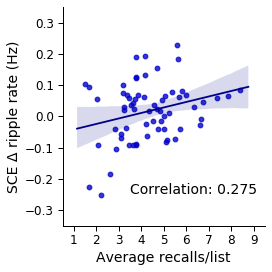

In [26]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 0
save_data_df = 0


sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})
print('Mixed model of ripple_rate ~ avg_recall_num at session-level')        
vc = {'session':'0+session'}
sig_bin_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num", sess_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model1.summary())
print(bin_model1.pvalues)
print(bin_model1.params)
print(bin_model1.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif location_selected == 'ca1':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
else:
    lmplot_color = (1,0,1)
    line_color = (1,0,1)    

# convert session-level df to subject-level for plot
sub_delta = []
sub_recall_num = []
sub_prop_semantic = []
for sub in np.unique(sess_subjects):
    sub_delta.append(np.mean(np.array(sess_delta)[np.array(sess_subjects) == sub]))
    sub_recall_num.append(np.mean(np.array(sess_recall_num)[np.array(sess_subjects) == sub]))
    sub_prop_semantic.append(np.mean(np.array(sess_prop_semantic)[np.array(sess_subjects) == sub]))

set_pubfig()
deltaRR_df = pd.DataFrame({'avg_recall_num':sub_recall_num,'ripple_rates':sub_delta,'prop_semantic':sub_prop_semantic})
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='avg_recall_num',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
    xticks(np.arange(1,7.5+0.01,1))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.5,9.5))
    xticks(np.arange(1,9.5+0.01,1))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_recall_num,sub_delta)

annotate('Correlation: '+str(np.round(plot_corr[0],3)),(3.5,-0.25)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
if save_data_df == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.p'
    with open(fname,'wb') as f:
        pickle.dump({'sess_df':sess_df}, f)
    
a=1;


## proportion of semantic recalls vs. SCE (make sure you run cell before first)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:    122       Method:               REML             
No. Groups:          65        Scale:                0.0014           
Min. group size:     1         Likelihood:           105.3045         
Max. group size:     6         Converged:            Yes              
Mean group size:     1.9                                              
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   -0.083    0.048 -1.709 0.087 -0.178  0.012
prop_semantic                0.247    0.109  2.275 0.023  0.034  0.460
subject Var                  0.000    0.226                           
subject x prop_semantic Cov -0.000    0.634                           
prop_semantic Var      

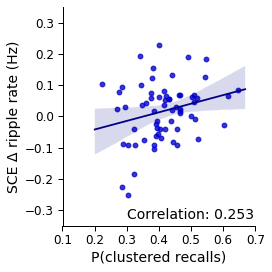

In [27]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 0

sig_bin_model2 = smf.mixedlm("delta_ripple_rate ~ prop_semantic", sess_df, groups="subject", vc_formula=vc,re_formula="prop_semantic")
bin_model2 = sig_bin_model2.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model2.summary())
print(bin_model2.pvalues)
print(bin_model2.params)
print(bin_model2.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

set_pubfig()
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='prop_semantic',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

xticks(np.arange(0,0.701,0.1))
if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.1,0.7))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_prop_semantic,sub_delta)

if location_selected == 'ca1':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.33)) 
elif location_selected == 'dg':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.25))
else:
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.25)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ ripple rate (Hz)')
xlabel('P(clustered recalls)')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/SCE_v_clustered_recalls_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
    
a=1;


### plot three (or two) on same

done making binned start_array with shape:
(17765, 30)
done making binned start_array with shape:
(14330, 30)


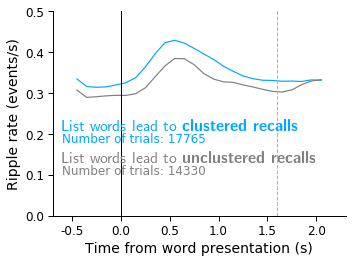

In [128]:
# (make sure you run semantic clustering for catFR cell first)

save_fig = 0
plot_SE = 0 # if you only want to do stats making this 0 will be much quicker since it doesn't do the ME model at each bin
            # this must be 1 if plot_ME_mean is 1
plot_ME_mean = 0 # 0 for typical PSTH; 1 for ME mean; 2 for average across sub averages

# get PSTH for two of the types
plot_three = [6,4] ## for clust v. unclust model: [5,4,6] # SCE contrast: [4,6]; SME contrast: # [5,4]
# 0 is adjacent_semantic, 1 is remote_semantic, 
# 2 is remote unclustered, 3 is dead end, 
# 4 is combined remote unclustered & dead end
# 5 is not recalled
# 6 is combined clustering (adjacent semantic and remote semantic)

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
text_height = 0.21

ripple_bin_start_end = [100,1700]
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
# comes to 400:1200 for 100 to 1700 of 1500 len timeseries

ME_start_array = []
ME_sub_name_array = []
ME_session_name_array = []
ME_indicator = [] # keeps track of trial type in comparison defined above (e.g. clustered v. not)

# for recalled and then forgotten words
for i_array,array_num in enumerate(plot_three):
    if array_num == 0:
        temp_start_array = adj_semantic_encoding_array
#         label = 'List words lead to \\textbf{semantic transition}'        
        label = 'List words lead to \\textbf{adjacent semantic}'
        plot_color = (1,0.33,0)
    elif array_num == 1:
        temp_start_array = rem_semantic_encoding_array
        label = 'List words lead to \\textbf{remote semantic}'
        plot_color = (0,0.66,1)
    elif array_num == 2:
        temp_start_array = rem_unclustered_encoding_array
        label = 'List words lead to \\textbf{remote unclustered}'
        plot_color = (0,0.3,0)
    elif array_num == 3:
        temp_start_array = last_recall_encoding_array
        label = 'List words lead to \\textbf{dead end}'
        plot_color = (0,0,0.3)
    elif array_num == 5:
        temp_start_array = forgot_encoding_array
        label = 'List words later \\textbf{not recalled}'
        plot_color = (.66,0.33,0)
        if location_selected == '':
            text_height = 0.125        
    elif array_num == 4:
        temp_start_array = superVstack(rem_unclustered_encoding_array,last_recall_encoding_array)
        label = 'List words lead to \\textbf{unclustered recalls}'
        plot_color = (0.5,0.5,0.5)
        sub_name_array4 = sub_name_array2+sub_name_array3
        sess_name_array4 = sess_name_array2+sess_name_array3
        elec_name_array4 = elec_name_array2+elec_name_array3
        if location_selected == '':
            text_height = 0.125
    elif array_num == 6:
        temp_start_array = superVstack(adj_semantic_encoding_array,rem_semantic_encoding_array)
        label = 'List words lead to \\textbf{clustered recalls}'
        if location_selected == 'ca1':
            plot_color = (0,0.66,1)
            text_height = 0.21
        elif location_selected == 'dg':
            plot_color = (1,0.33,0.66)
            text_height = 0.21
        else:
            plot_color = (1,0,1)
            text_height = 0.125
        sub_name_array6 = sub_name_array0+sub_name_array1
        sess_name_array6 = sess_name_array0+sess_name_array1
        elec_name_array6 = elec_name_array0+elec_name_array1        
    else:
        print('not using this array_num, pick another my guy')
        break
        
    sub_name_array = eval('sub_name_array'+str(array_num))
    sess_name_array = eval('sess_name_array'+str(array_num))
    elec_name_array = eval('elec_name_array'+str(array_num))
    
    # update accumulating totals for ME model
    ME_start_array = superVstack(ME_start_array,temp_start_array)
    ME_sub_name_array = np.concatenate((ME_sub_name_array,sub_name_array))
    ME_session_name_array = np.concatenate((ME_session_name_array,sess_name_array))
    ME_indicator.extend(np.repeat(i_array,len(temp_start_array)))

    if array_num == plot_three[0]:
        # for plot
        subplots(1,1,figsize=(5,3.75))
        text(-600,text_height,label,usetex=True,size=16,color=plot_color) 
        text(-600,text_height-0.03,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    elif array_num == plot_three[1]:
        text(-600,text_height-0.08,label,usetex=True,size=16,color=plot_color) 
        text(-600,text_height-0.11,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    else:
        text(-600,0.05,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.02,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)        
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)

    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SE == True:
        mean_plot,SE_plot = getMixedEffectMeanSEs(binned_start_array,sub_name_array,sess_name_array) #,elec_name_array)
        print('SEs created!')
        
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)
    elif plot_ME_mean == 2: # average across subs first
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(binned_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
        PSTH = PSTH[pad:-pad] 
        if plot_SE == True:
            SE_plot = SE_plot[:,pad:-pad]
    
    plot(xr,PSTH,color=plot_color)
    if plot_SE == True:
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3, facecolor=plot_color)
        
xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
       np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
xlabel('Time from word presentation (s)',fontsize=14)
ylabel('Ripple rate (events/s)',fontsize=14)
ax = plt.gca()
ylim = 0.5
ax.set_ylim(0,ylim)
ax.set_xlim(pre_encoding_time,encoding_time)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

# cell below uses comp_str so grab it regardless
if type(location_selected)==list:
    location_selected = 'ca1dg'
if len(plot_three)==3:
    comp_str = str(plot_three[0])+'-'+str(plot_three[1])+'-'+str(plot_three[2])
elif len(plot_three)==2:
    comp_str = str(plot_three[0])+'-'+str(plot_three[1])
        
if save_fig == 1:
    # get strings for path name for save and loading cluster data

    path_name = '/home1/john/SWR/figures/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'_'+str(plot_ME_mean)+'.pdf')
    plt.savefig(fn,transparent=True)  

a=1;

In [129]:
# SCE model

save_data = 1 # saving the data lets you do the SCE * brain_region interaction below

import statsmodels.api as sm
import statsmodels.formula.api as smf
## for the stats for each of these I'm comparing the first two to the 3rd one
# i.e. [0,1,4] is adjacent and remote semantic each vs. combined SME
# and [2,3,5] is remote unclustered and dead end each vs. not recalled
ME_ripple_rate = np.sum(ME_start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'session':ME_sub_name_array,'subject':ME_session_name_array})
vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ C(indicator)", clust_df, groups="subject", vc_formula=vc,re_formula="C(indicator)")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)

# if want to save data to compare across regions

if save_data == 1:

    path_name = '/home1/john/SWR/compiled/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p')           
    with open(fn,'wb') as f:
        pickle.dump({'clust_df':clust_df,'comp_str':comp_str}, f)
        
# R1 asked for ANOVA as well (do this after saving clust_df or can't save full df for indicator*region test below)
key = ['subject','indicator']
clust_df = clust_df.groupby(key).mean().reset_index() # averages ripple rates for correct and incorrect within each patient
OLS_model = smf.ols("ripple_rate ~ indicator", clust_df).fit()
print('Simple ANOVA:')
print(OLS_model.summary())        



/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      ripple_rate
No. Observations:        32095        Method:                  REML       
No. Groups:              162          Scale:                   0.2919     
Min. group size:         7            Likelihood:              -25982.7459
Max. group size:         1935         Converged:               Yes        
Mean group size:         198.1                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.335    0.013 25.869 0.000  0.310  0.361
C(indicator)[T.1]               -0.024    0.008 -3.035 0.002 -0.039 -0.008
subject Var                      0.011                                    
subject x C(indicator)[T.1] Cov -0.002    0.

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Comparing clustered and unclustered directly

In [83]:
import statsmodels.formula.api as smf

# Need to run [5,4,6] to get the correct df, since need the not recalled (5), recalled but not clustered (4), and clustered (6)

ME_ripple_rate = np.sum(ME_start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'session':ME_sub_name_array,'subject':ME_session_name_array})

# now alter this df to make a recalled column and a clustered column
clust_df['clustered'] = clust_df.indicator==2
clust_df['recalled'] = clust_df.indicator!=0

vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ recalled+clustered", clust_df, groups="subject", vc_formula=vc,
                          re_formula="recalled+clustered")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          ripple_rate
No. Observations:          61255            Method:                      REML       
No. Groups:                102              Scale:                       0.2974     
Min. group size:           91               Likelihood:                  -50020.1605
Max. group size:           1782             Converged:                   Yes        
Mean group size:           600.5                                                    
------------------------------------------------------------------------------------
                                         Coef.   Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.332     0.014 23.331 0.000  0.304  0.360
recalled[T.True]                         -0.002     0.010 -0.168 0.867 -0.021  0.018
clus

### Comparison across regions (using data saved from last cell

In [124]:
import statsmodels.formula.api as smf

regions_to_compare = ['ENTPHC','HPC'] # put one you want as 0 first
locations_for_regions = ['','dg'] # THIS NEEDS TO MATCH WITH PREVIOUS LINE
comps = [6,4] # I saved the dataframes as clustered and unclustered comparisons so unpack from this

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    comp_str = str(comps[0])+'-'+str(comps[1])
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p') 

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['clust_df']))
    if reg == 0:
        comb_df = dat['clust_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['clust_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}
comb_df.indicator = 1-comb_df.indicator # so clustered is now 1
reg_model = smf.mixedlm("ripple_rate ~ indicator*region", comb_df, groups="subject", vc_formula=vc,
                        re_formula='indicator:region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

190
18188


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 14 and the array at index 1 has size 12

## same idea but comparing SCE v. recall and p(clustering) plots between regions

In [19]:
import statsmodels.formula.api as smf

regions_to_compare = ['ENTPHC','HPC'] # put one you want as 0 first
locations_for_regions = ['','dg'] # THIS NEEDS TO MATCH LOGIC OF PREVIOUS LINE
sub_selection = 'second_half' # 'second_half' # don't need to load anything previous as long as saved data using "save_data_df" previously

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    fn = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.p'

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['sess_df']))
    if reg == 0:
        comb_df = dat['sess_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['sess_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}
reg_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num*region", comb_df, groups="subject", vc_formula=vc, re_formula='avg_recall_num*region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Avg_recall_num X region model:****')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)


reg_model = smf.mixedlm("delta_ripple_rate ~ prop_semantic*region", comb_df, groups="subject", vc_formula=vc, re_formula='prop_semantic*region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Prop_semantic X region model****:')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})

59
61


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 

****Avg_recall_num X region model:****
                        Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        delta_ripple_rate
No. Observations:         120            Method:                    REML             
No. Groups:               47             Scale:                     0.0096           
Min. group size:          1              Likelihood:                90.8840          
Max. group size:          10             Converged:                 Yes              
Mean group size:          2.6                                                        
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.070    0.035  1.978 0.048  0.001  0.139
avg_recall_num                         

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


****Prop_semantic X region model****:
                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       delta_ripple_rate
No. Observations:         120           Method:                   REML             
No. Groups:               47            Scale:                    0.0090           
Min. group size:          1             Likelihood:               93.9888          
Max. group size:          10            Converged:                Yes              
Mean group size:          2.6                                                      
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.092    0.065  1.405 0.160 -0.036  0.219
prop_semantic                            -0.170    0.130 -1.3

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [ ]:
# this was a df for David
path_name = '/home1/john/SWR/compiled/'
comp_str = str(plot_three[0])+'-'+str(plot_three[1])+'-'+str(plot_three[2])
fn1 = os.path.join(path_name,
    'semantic_clustering_'+exp+'_'+region_name+'_'+\
    location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p')
with open(fn1,'wb') as f:
    pickle.dump({'clust_df':clust_df,
                 'adj_semantic_encoding_array':adj_semantic_encoding_array,
                 'rem_semantic_encoding_array':rem_semantic_encoding_array,
                 'rem_unclustered_encoding_array':rem_unclustered_encoding_array,
                 'dead_end_encoding_array':last_recall_encoding_array,
                 'not_recalled_encoding_array':forgot_encoding_array,
                 'sess_name_array0':sess_name_array0,'sub_name_array0':sub_name_array0,
                  'sess_name_array1':sess_name_array1,'sub_name_array1':sub_name_array1,
                  'sess_name_array2':sess_name_array2,'sub_name_array2':sub_name_array2,
                  'sess_name_array3':sess_name_array3,'sub_name_array3':sub_name_array3,
                  'sess_name_array5':sess_name_array5,'sub_name_array5':sub_name_array5,
                  'elec_name_array0':elec_name_array0,
                  'elec_name_array1':elec_name_array1,
                  'elec_name_array2':elec_name_array2,
                  'elec_name_array3':elec_name_array3,
                  'elec_name_array5':elec_name_array5,
                  'encoding_range':encoding_range,'sr':sr}, f)

# Plot 1st half v. 2nd half of serial positions

In [38]:
# will run both of these below, but only need to get sub and sess info once

serialpos_select1 = np.arange(1,7) #np.arange(1,7) # np.arange(1:13)

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

adj_semantic_encoding_array = []
rem_semantic_encoding_array = []
rem_unclustered_encoding_array = []
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
adj_semantic_encoding_array_2nd = []
rem_semantic_encoding_array_2nd = []
rem_unclustered_encoding_array_2nd = []
last_recall_encoding_array_2nd = []
sub_name_array0 = []; sess_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []
sub_name_array0_2nd = []; sess_name_array0_2nd = []
sub_name_array1_2nd = []; sess_name_array1_2nd = []
sub_name_array2_2nd = []; sess_name_array2_2nd = []
sub_name_array3_2nd = []; sess_name_array3_2nd = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                
                recall_position = list_ch_recall_positions[0][i_recall_type]
                
                if recall_position in serialpos_select1: # select first half

                    if recall_type == 'A': # adjacent semantic
                        # note the -1 since recall positions are on scale of 1-12
                        adj_semantic_encoding_array = superVstack(adj_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6]) # grab subject name string
                        sess_name_array0.append(sess) # session name will be unique beacuse it's actually sub+sess
                    elif recall_type == 'C': # remote semantic
                        rem_semantic_encoding_array = superVstack(rem_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                    elif ( (recall_type == 'D') & (recall_position>0) ): # remote unclustered
                        rem_unclustered_encoding_array = superVstack(rem_unclustered_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)                    
                    elif ( (recall_type == 'Z') & (recall_position>0) ): # last word of list & was actually a recalled word
                        last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        
                else: # second half of serialpos
                
                    if recall_type == 'A': # adjacent semantic
                        # note the -1 since recall positions are on scale of 1-12
                        adj_semantic_encoding_array_2nd = superVstack(adj_semantic_encoding_array_2nd,list_ch_encoding_array[recall_position-1])
                        sub_name_array0_2nd.append(sess[0:6]) # grab subject name string
                        sess_name_array0_2nd.append(sess) # session name will be unique beacuse it's actually sub+sess
                    elif recall_type == 'C': # remote semantic
                        rem_semantic_encoding_array_2nd = superVstack(rem_semantic_encoding_array_2nd,list_ch_encoding_array[recall_position-1])
                        sub_name_array1_2nd.append(sess[0:6])
                        sess_name_array1_2nd.append(sess)
                    elif ( (recall_type == 'D') & (recall_position>0) ): # remote unclustered
                        rem_unclustered_encoding_array_2nd = superVstack(rem_unclustered_encoding_array_2nd,list_ch_encoding_array[recall_position-1])
                        sub_name_array2_2nd.append(sess[0:6])
                        sess_name_array2_2nd.append(sess)                    
                    elif ( (recall_type == 'Z') & (recall_position>0) ): # last word of list & was actually a recalled word
                        last_recall_encoding_array_2nd = superVstack(last_recall_encoding_array_2nd,list_ch_encoding_array[recall_position-1])
                        sub_name_array3_2nd.append(sess[0:6])
                        sess_name_array3_2nd.append(sess)                        

done making binned start_array with shape:
(1716, 26)
SEs created!
done making binned start_array with shape:
(1095, 26)
SEs created!


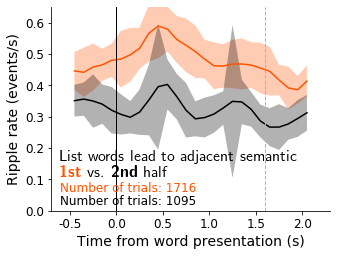

done making binned start_array with shape:
(2126, 26)
SEs created!
done making binned start_array with shape:
(1318, 26)
SEs created!


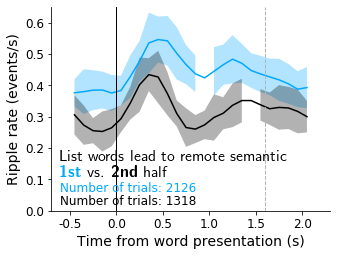

done making binned start_array with shape:
(1194, 26)
SEs created!
done making binned start_array with shape:
(1607, 26)
SEs created!


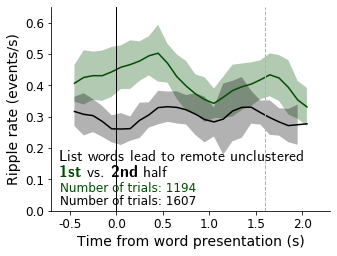

done making binned start_array with shape:
(834, 26)
SEs created!
done making binned start_array with shape:
(1014, 26)
SEs created!


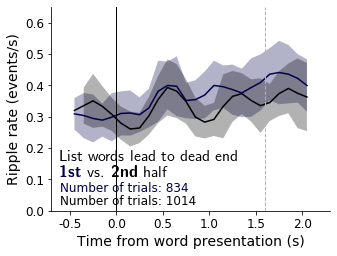

In [39]:
# plot the split halves

import warnings

save_fig = 0
plot_SE = 1

# get PSTH for two of the types
plot_type = 0
# 0 is adjacent_semantic, 1 is remote_semantic, 2 is remote unclustered, 3 is dead end

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?                        
                        

# for recalled and then forgotten words
for array_num in range(4):
    for half in [1,2]:
        if half == 1:
            extra = ''
        else:
            extra = '_2nd'
        if array_num == 0:
            temp_start_array = eval('adj_semantic_encoding_array'+extra)
            label = 'List words lead to adjacent semantic'
            plot_color1 = (1,0.33,0)
        elif array_num == 1:
            temp_start_array = eval('rem_semantic_encoding_array'+extra)
            label = 'List words lead to remote semantic'
            plot_color1 = (0,0.66,1)
        elif array_num == 2:
            temp_start_array = eval('rem_unclustered_encoding_array'+extra)
            label = 'List words lead to remote unclustered'
            plot_color1 = (0,0.3,0)
        elif array_num == 3:
            temp_start_array = eval('last_recall_encoding_array'+extra)
            label = 'List words lead to dead end'
            plot_color1 = (0,0,0.3)
        plot_color_black = (0,0,0)        
        sub_name_array = eval('sub_name_array'+str(array_num)+extra)
        sess_name_array = eval('sess_name_array'+str(array_num)+extra)

        if half == 1:
            subplots(1,1,figsize=(5,3.75))        
            text(-600,0.16,label,usetex=True,size=16,color=plot_color_black)
            text(-600,0.11,'\\textbf{1st}',usetex=True,size=16,color=plot_color1)
            text(-320,0.11,'vs. \\textbf{2nd} half',usetex=True,size=16,color=plot_color_black)
            text(-600,0.06,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color1,size=12)
        else:
            text(-600,0.02,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color_black,size=12)        

        # make a PSTH based on start times of SWRs

        PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)

        # get binned start array (trials X bins)
        binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
        if pad > 0:
            binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
        print('done making binned start_array with shape:')
        print(binned_start_array.shape)

        # note that output is the net ± distance from mean
        if plot_SE == True:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                SE_plot = getMixedEffectSEs(binned_start_array,sub_name_array,sess_name_array)
                print('SEs created!')

        # plot
        xr = bin_centers #np.arange(psth_start,psth_end,binsize)
        xr = xr[pad:-pad]; 

        plot(xr,PSTH[pad:-pad],color=eval('plot_color'+str(half)))
        if plot_SE == True:
            fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3, facecolor=eval('plot_color'+str(half)))
        
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)',fontsize=14)
    ylabel('Ripple rate (events/s)',fontsize=14)
    ax = plt.gca()
    ylim = 0.65
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    xticks(fontsize=12)
    yticks(fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.show()
    
        
    if save_fig == 1:
        # get strings for path name for save and loading cluster data

        if os.path.isdir(path_name) == False:
            os.mkdir(path_name)
        if type(location_selected)==list:
            location_selected = 'ca1dg'

        if save_fig == 1:        
            fname = '/home1/john/SWR/figures/ENCODING/semantic_clustering_first_second_half_'+exp+'_'+region_name+'_'+\
                location_selected+'_'+filter_type+'_'+sub_selection+'_'+str(array_num)+'.pdf'
            savefig(fname,format='pdf',transparent=True) 
        
a=1;                        

# Repeated category analysis: go down to the list level and pick out which words are 1st, 2nd, 3rd, and 4th repeats of each *category*. This also sets up for serialpos analyses and regression below

In [14]:
%autoreload

select_category_repeat = 0 # 1, 2, 3, 0 # 0 means use all categories. 1:3 mean select only 1st, 2nd, 3rd usage of category

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors

session_names = np.unique(session_name_array)
r1 = [] # 4 ripple arrays
r2 = []
r3 = []
r4 = []
r1r4_subject_name_array = []
r1r4_session_name_array = []
r6 = [] # one idea to account for drop in ripples in each encoding period: compare 6th word (always a 2nd of 1st cat) to 7th (always 3rd of a cat)
r7 = [] 
r6_sub_array = []; r7_sub_array = []
r6_sess_array = []; r7_sess_array = []

# accumulated arrays for regression
category_presentation = []
word_presentation_serialpos = []
word_presentation_ripples = []
regression_subject_name_array = []
regression_session_name_array = []

# session_names = ['R1239E-1']

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
    
    if exp == 'catFR1':
        # get indicator of whether category is 1st, 2nd, or 3rd time used in a given session 
        category_repeat_array = getCategoryRepeatIndicator(sess,electrode_array,session_name_array,category_array)    
        num_elecs_in_session = len(np.unique(electrode_array[(session_name_array==sess)]))
        if num_elecs_in_session > 1:
            category_repeat_array = np.tile(category_repeat_array,num_elecs_in_session)
    session_list_num_key = list_num_key[session_name_array==sess] # need this so can get the right category_repeats by list_num below
        
    for ln in sess_list_nums:
        
        if exp == 'catFR1':
            # for each list in each session, figure out which encoding events are 1st, 2nd, 3rd, and 4th from each category
            # (could really do this at the session-level but just in case a list was repeated somehow do it at the list-level)
            list_cats = category_array[((session_name_array==sess) & (list_num_key==ln))] # note that this is this list for *every* electrode
            list_category_repeat_array = category_repeat_array[session_list_num_key==ln] # indicator of category repeats across lists (for current ln)
        else:
            list_cats = [1,1,1,1,2,2,2,2,3,3,3,3] # just so it passes next if statement
        list_start_array = start_array[((session_name_array==sess) & (list_num_key==ln))]
        
        if ( (len(list_cats) % 12 == 0) and (len(np.unique(list_cats)) == 3) ): # make sure all the words were presented for this session and there are 3 categories
            
            # get these arrays for SE_plot hierarchical model
            quarter_session_trials = int(sum((session_name_array==sess) & (list_num_key==ln))/4)
            r1r4_subject_name_array.extend(subject_name_array[((session_name_array==sess) & (list_num_key==ln))][0:quarter_session_trials])
            r1r4_session_name_array.extend(session_name_array[((session_name_array==sess) & (list_num_key==ln))][0:quarter_session_trials])
            
            # serialpositions for regression of list number v. category number
            word_presentation_serialpos.extend(serialpos_array[((session_name_array==sess) & (list_num_key==ln))])
            regression_subject_name_array.extend(subject_name_array[((session_name_array==sess) & (list_num_key==ln))])
            regression_session_name_array.extend(session_name_array[((session_name_array==sess) & (list_num_key==ln))])            
         
            cat_counter = [0,0,0]
            unique_cats = np.unique(list_cats)
                        
            if exp == 'catFR1':
                # for every trial use the category name to append to the right ripple array    
                for i_word_cat,word_cat in enumerate(list_cats): 
                    cat_idx = int(findInd(unique_cats == word_cat)) # get index for which of 3 categories this word is from
                    current_count = cat_counter[cat_idx] # get current count for how many times this word has been used   


                    # keep track of information for regression of list number v. category number
                    category_presentation.append(current_count % 4) # keep track of category presentation number (1st-4th time category used)

                    # get ripples in 100:1700 bin for ME model
                    if exp == 'catFR1':
                        word_presentation_ripples.append( sum(list_start_array[i_word_cat,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor):
                                                                                          int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)]) )
                    elif exp == 'FR1':
                        # this seems wrong but it was working this way???
                        word_presentation_ripples.extend( sum(list_start_array[i_word_cat,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor):
                                                                                          int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)],1) )                        

                    # if selecting for how many times this category is repeated (select_category_repeat==0 means keep all)
                    if ( (list_category_repeat_array[i_word_cat] == select_category_repeat) | (select_category_repeat==0) ):

                        if current_count % 4 == 0:
                            r1 = superVstack(r1,list_start_array[i_word_cat])
                        elif current_count % 4 == 1:
                            r2 = superVstack(r2,list_start_array[i_word_cat])                    
                        elif current_count % 4 == 2:
                            r3 = superVstack(r3,list_start_array[i_word_cat])  
                        elif current_count % 4 == 3:
                            r4 = superVstack(r4,list_start_array[i_word_cat])                      

                    cat_counter[int(findInd(unique_cats == word_cat))] +=1 # increment counter for this category

                    # separately, just record the 6th and 7th words in each list only
                    if i_word_cat % 11 == 5:
                        r6 = superVstack(r6,list_start_array[i_word_cat])
                        r6_sub_array.append(r1r4_subject_name_array[-1])
                        r6_sess_array.append(r1r4_session_name_array[-1])                    
                    if i_word_cat % 11 == 6:
                        r7 = superVstack(r7,list_start_array[i_word_cat])
                        r7_sub_array.append(r1r4_subject_name_array[-1])
                        r7_sess_array.append(r1r4_session_name_array[-1]) 
            else:
                # for FR1 just append without going through categories
                word_presentation_ripples.extend( sum(list_start_array[:,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor):
                                                                                 int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)],1) )
                
        else:
            print(sess)
            print(ln)
                    
# sanity check (should not matter since the if statement above should take care of everything)                
if ( (len(r1)!=len(r4)) or (len(r1)!=len(r1r4_session_name_array)) ):
    if select_category_repeat == 0:
        print('There is something wrong, we do not have the same number of trials in ripple array or session_name_array')

In [204]:
# these three should be the same after running above cell
len(regression_session_name_array)
len(word_presentation_serialpos)
len(word_presentation_ripples)

28920

28920

28920

## plot PSTH for all 4 encoding categories: Novel, 1st, 2nd, and 3rd repeat of category

done making binned start_array with shape:
(8298, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
done making binned start_array with shape:
(8298, 26)
done making binned start_array with shape:
(8298, 26)
done making binned start_array with shape:
(8298, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


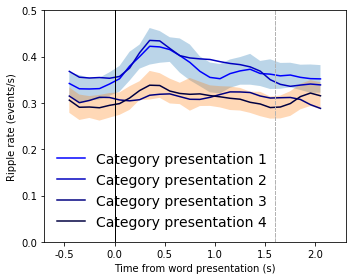

In [19]:
%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# subject_name_array and session_name_array are the same for all 4 

# for 4 presentations of same category
for category in range(4):
    if category == 0:
        temp_start_array = r1
        
        # for plot
        subplots(1,1,figsize=(5,4))        
        plot_color = (0,0,1) #(1,0,0)
        label = 'Category presentation 1'
#         text(500,0.21,label,usetex=True,size=16,color=plot_color)
#         text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    elif category == 1:       
        label = 'Category presentation 2'
        temp_start_array = r2        
        plot_color = (0,0,0.75) #(0.75,0,0)
    elif category == 2:       
        label = 'Category presentation 3'
        temp_start_array = r3        
        plot_color = (0,0,0.5) # (0.5,0,0)
    elif category == 3:       
        label = 'Category presentation 4'
        temp_start_array = r4        
        plot_color = (0,0,0.25) #(0.25,0,0)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean

    if (plot_SEs == 1) & (category in [0,3]):
        SE_plot = getMixedEffectSEs(binned_start_array,r1r4_subject_name_array,r1r4_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    
    if (plot_SEs == 1) & (category in [0,3]):
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
leg = ax.legend(frameon=False,prop={'size': 14})
a=1;

# Daniel and David are suggesting complementary analyses of remembering one category dependent on ripples during presentation of the same category at different times (make sure you get category_presentation from a few cells above)

In [15]:
# first let's get the set of trials where a ripple happened on the second category presentation 
# (the 3rd and 4th words from a category)

cat_3_12_same = [] # same category 1 & 2 as 3 with a ripple (2 per list)
cat_3_12_diff = [] # diff category 1 & 2 as 3 with a ripple (4 per list)
cat_2_34_same = [] # same category 3 & 4 as 2 with a ripple (2 per list)
cat_2_34_diff = [] # diff category 3 & 4 as 2 with a ripple (2 per list)
cat_1_234_same = [] 
cat_1_234_diff = [] 
cat_2_1_same = [] 
cat_2_1_diff = [] 
# variables for the 3rd/4th from category correct analysis (2nd row is for model)
cat_12ripple_34corr = []; cat_12ripple_34corr_ripple = []; cat_12NO_34_corr_ripple = []; cat_12NO_34_corr_NO = []; 
cat_12ripple_12corr = []; cat_12ripple_12corr_ripple = []; cat_12NO_12_corr_ripple = []; cat_12NO_12_corr_NO = []; 
accum_34corr = []; accum_12corr = []; 
sub_34corr = []; sess_34corr = []; 
ripple12 = []; ripple34 = []; 
otherRR_34 = []; otherRR_34corr_incl34 = []
otherRR_1sthalf = []; otherRR_2ndhalf = []

accum_1234corr = []; otherRR1234 = []; ripple1234 = []; ripple1234_rate = []
sub_1234 = []; sess_1234 = []

cat_12_34ripple_34 = []
cat_12_34noripple_34 = []
cat_12_34ripple_12 = []
cat_12_34noripple_12 = []
cat_12recall_34recall = []
cat_12recall_34norecall = []
cat1ripple_C1_C2_C1C2_C2C1 = []

session_names = np.unique(session_name_array) # only need this if used below for debug or didn't run the cell 2 above
# session_names = ['R1065J-2'] # goot sesion for debug

for sess in session_names: # if it's bugging out here it's because you didn't run cell 2 above
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_presentations = np.array(category_presentation)[list_ch_idxs] # note this is 1 to 4
            list_ch_encoding_array = start_array[list_ch_idxs,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor): 
                                                   int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            
            # the simplest models are like this:
            # If ripple in C1 (word 1 from category C), person recalls C1->C2
            # ..........................................person recalls C2->C1 (control)
            # If ripple in C2 (word 2 from category C), person recalls C2->C1
            # ..........................................person recalls C1->C2 (control)
            # can then do all the same for C3 & C4
            
            first_of_pair = 0 # can select 1st of category or 3rd (0 or 2 here)
            for list_ind in findInd(list_ch_presentations==first_of_pair): # 1st category pres in list (or 3rd if change to 2)
                if sum(list_ch_encoding_array[list_ind,:])==0: # if there's a ripple... (change this to ==0 for comparison to no ripple)
                                                            # can also change to list_ind+1 here to see if ripple happens in C2, what happens to others?
                                                            # or change to list_ind:list_ind+2 to see ripple in CA1 *or* C2
                    
                    # create vector of [C1 correct, C2 correct, C1->C2 correct, C2->C1 correct, C3/C4 correct, C1->C3/C4, C3/C4->C1]
                    temp_vector = np.zeros(7)
                    recall_order = np.array(recall_position_array[list_ch_idxs][0])-1 # these are 1-indexed so subtract 1

                    if list_ind in recall_order: # selects C1s
                        recall_ind = findInd(recall_order == list_ind)[0] # index for # of recalls
                        temp_vector[0]+=1
                        if ((recall_ind+1)<len(recall_order)) & (len(recall_order)>1): # if not last recall and at least 2 recalled
                            if recall_order[recall_ind+1] == (list_ind+1): # if next recall is C2
                                temp_vector[2]+=1
                               
                    if (list_ind+1) in recall_order: # selects C2s
                        recall_ind = findInd(recall_order == (list_ind+1))[0] # index for # of recalls
                        temp_vector[1]+=1
                        if ((recall_ind+1)<len(recall_order)) & (len(recall_order)>1): # if not last recall and at least 2 recalled
                            if recall_order[recall_ind+1] == (list_ind): # if next recall is C1
                                temp_vector[3]+=1                               
    
                    if first_of_pair == 0: # thish doesn't make sense if using 3rd from cat
                        # C3 and C4 from this same category as lind_ind
                        two_inds_from_cat = findInd(list_ch_cats==list_ch_cats[list_ind])[-2:]
                    elif first_of_pair == 2:
                        # C1 and C2 from same category
                        two_inds_from_cat = findInd(list_ch_cats==list_ch_cats[list_ind])[0:2]
                    if (two_inds_from_cat[0] in recall_order) or (two_inds_from_cat[0] in recall_order):                    
                        temp_vector[4]+=1
                        if list_ind in recall_order: # selects lists with C1 recalls:
                            recall_ind = findInd(recall_order == list_ind)[0] # position of recall
                            if ((recall_ind+1)<len(recall_order)) & (len(recall_order)>1): # if not last recall and at least 2 recalled
                                if recall_order[recall_ind+1] in two_inds_from_cat: # if next recall is C3/C4
                                    temp_vector[5]+=1

                            if ((recall_ind>0) & (len(recall_order)>1)): # if not 1st recall and at least 2 recalls
                                if (recall_ind-1) in two_inds_from_cat:
                                    temp_vector[6]+=1
                    cat1ripple_C1_C2_C1C2_C2C1 = superVstack(cat1ripple_C1_C2_C1C2_C2C1,temp_vector)                                    
            
            # Let's check category_presentation = 3 for ripples and see if it predicts better memory 
            # for the same category for category_presentation 1 or 2            
            for cat_3_idx in findInd(list_ch_presentations==2): # go through each of 3 categories (0-indexed)
                if sum(list_ch_encoding_array[cat_3_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentation 1 and 2 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_3_idx]
                    cat_3_12_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                    cat_3_12_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])

                    
            # same idea, but see if ripple during 2nd category presentation leads to better memory for 3&4
            for cat_2_idx in findInd(list_ch_presentations==1): # (0-indexed)
                if sum(list_ch_encoding_array[cat_2_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentation 3 and 4 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_2_idx]
                    cat_2_34_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                    cat_2_34_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])

            # same idea, but see if ripple during 1st category presentation leads to better memory for 2-4
            for cat_1_idx in findInd(list_ch_presentations==0): # (0-indexed)
                if sum(list_ch_encoding_array[cat_1_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentations 2-4 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_1_idx]
                    cat_1_234_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==1)|(list_ch_presentations==2)|(list_ch_presentations==3) )])
                    cat_1_234_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==1)|(list_ch_presentations==2)|(list_ch_presentations==3) )])
                    
            # For encoding-specific analysis...see if ripple during 2nd category presentation leads to better memory for 1st
            for cat_1_idx in findInd(list_ch_presentations==0): # (0-indexed)
                if sum(list_ch_encoding_array[cat_1_idx:cat_1_idx+2,:])>0: # if there's a ripple in either 1st or 2nd pres
                    # ...check accuracy of presentations 3-4 from this same cat
                    selected_cat = list_ch_cats[cat_1_idx]
                    cat_2_1_same.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                else: # if no ripple
                    cat_2_1_diff.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])   
                    
                                    
                    
            # Taking into account last analysis...see if ripple during 2nd category presentation change anything
            for cat_1_idx in findInd(list_ch_presentations==0): # (0-indexed)...logic is to go through 1st pres of each cat
                
                selected_cat = list_ch_cats[cat_1_idx]
                
                # do simple category accumulations
                accum_1234corr.extend(list_ch_corr[list_ch_cats==selected_cat])
                if sum(list_ch_encoding_array[list_ch_cats==selected_cat,:])>0:
                    ripple1234.extend(np.zeros(4))
                else:
                    ripple1234.extend(np.ones(4))
                ripple1234_rate.extend(np.repeat(sum(list_ch_encoding_array[list_ch_cats==selected_cat,:])/len(list_ch_cats==selected_cat)/1.6
                                                ,4))
                sub_1234.extend(np.repeat(sess[0:6],4))                        
                sess_1234.extend(np.repeat(sess,4)) 
                    
                if sum(list_ch_encoding_array[cat_1_idx:cat_1_idx+2,:])>0: # if there's a ripple in either 1st or 2nd pres of cat
                    # ...check accuracy of presentations 3-4 from this same cat
                    selected_cat_3rd_pres = findInd((list_ch_cats==selected_cat) & (list_ch_presentations==2))[0]
                    # if there a ripple in 3rd and 4th too!
                    if sum(list_ch_encoding_array[selected_cat_3rd_pres:selected_cat_3rd_pres+2,:])>0:
                        cat_12ripple_34corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_34corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_12corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                        sub_34corr.extend(np.repeat(sess[0:6],2))
                        sess_34corr.extend(np.repeat(sess,2))
                        ripple34.extend(np.ones(2))
                    else: # if no ripple in 3rd/4th
                        cat_12ripple_34corr_ripple.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])                     
                        accum_34corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])                     
                        accum_12corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                        sub_34corr.extend(np.repeat(sess[0:6],2))                        
                        sess_34corr.extend(np.repeat(sess,2)) 
                        ripple34.extend(np.zeros(2))
                    ripple12.extend(np.ones(2))    
                else: # if no ripple in 1st/2nd pres of category
                    # get index of 3rd pres from same cat
                    selected_cat_3rd_pres = findInd((list_ch_cats==selected_cat) & (list_ch_presentations==2))[0]
                    # if there a ripple in 3rd and 4th only!
                    if sum(list_ch_encoding_array[selected_cat_3rd_pres:selected_cat_3rd_pres+2,:])>0:
                        cat_12NO_34_corr_ripple.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_34corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_12corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                        sub_34corr.extend(np.repeat(sess[0:6],2))                        
                        sess_34corr.extend(np.repeat(sess,2))
                        ripple34.extend(np.ones(2))
                    else: # no ripple in either!
                        cat_12NO_34_corr_NO.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_34corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                        accum_12corr.extend(list_ch_corr[ (list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                        sub_34corr.extend(np.repeat(sess[0:6],2))                        
                        sess_34corr.extend(np.repeat(sess,2)) 
                        ripple34.extend(np.zeros(2))
                    ripple12.extend(np.zeros(2))
                    

                # find ripple rate for rest of list (other two categories essentially)
                remaining_word_idxs = findInd(list_ch_cats!=selected_cat)
                otherRR1234.extend( np.repeat(
                    sum(list_ch_encoding_array[remaining_word_idxs,:])/len(remaining_word_idxs)/1.6, 4) ) # for each cat_1_idx add 4 other ripple rates
                otherRR_34.extend( np.repeat(
                    sum(list_ch_encoding_array[remaining_word_idxs,:])/len(remaining_word_idxs)/1.6, 2) ) # 2 3/4words were added for each cat_1_idx
                remaining_words_with_34 = np.union1d(remaining_word_idxs,np.arange(6,12))
                otherRR_34corr_incl34.extend(np.repeat(
                    sum(list_ch_encoding_array[remaining_words_with_34,:])/len(remaining_words_with_34)/1.6, 2) ) # same but including all second half of list words
                # rest of list RR for 1st/2nd half
                other_1sthalf_idxs = np.intersect1d(remaining_word_idxs,np.arange(6))
                otherRR_1sthalf.extend(np.repeat(
                    sum(list_ch_encoding_array[other_1sthalf_idxs,:])/len(other_1sthalf_idxs)/1.6, 2) )
                other_2ndhalf_idxs = np.intersect1d(remaining_word_idxs,np.arange(6,12))
                otherRR_2ndhalf.extend(np.repeat(
                    sum(list_ch_encoding_array[other_2ndhalf_idxs,:])/len(other_2ndhalf_idxs)/1.6, 2) )
                    
                    
            # David's idea is he expects if there are ripples on 3rd/4th trial...
            # there will be greater p(recall 3/4 | recall 1/2) (given a 1/2 recall already happened)
            for cat_12_idx in findInd(list_ch_presentations==0): # (0-indexed) # 2022-03-22 changing this to be 1 and/or 2 so don't double count with list_ch_presentations==1
                first_two_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[0:2]
                same_cat_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[2:] # grab idxs of 3rd and 4th from this same category              
                if sum(list_ch_corr[first_two_idxs]) > 0: # if recalled either 1/2...
                    if sum(list_ch_encoding_array[same_cat_idxs])>0: # if ripple in either 3rd or 4th trial
                        cat_12_34ripple_34.extend(list_ch_corr[same_cat_idxs])
                    else:
                        cat_12_34noripple_34.extend(list_ch_corr[same_cat_idxs])
#             # similar idea...if ripple during 1/2 words there will be greater p(recall 3/4 | recall 1/2) 
#             for cat_12_idx in findInd( (list_ch_presentations==0)|(list_ch_presentations==1) ): # (0-indexed)
#                 if list_ch_corr[cat_12_idx] == 1: # if recalled 1/2...
#                     first_two_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[0:2]
#                     same_cat_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[2:] # grab idxs of 1st and 2nd from this same category
#                     if sum(list_ch_encoding_array[first_two_idxs])>0: # if ripple in either 3rd or 4th trial
#                         cat_12_34ripple_12.extend(list_ch_corr[same_cat_idxs])
#                     else:
#                         cat_12_34noripple_12.extend(list_ch_corr[same_cat_idxs])   
                        
            # actually we think it would make more sense to show ripple rates for recall vs. no recall
            # so p(ripple 3/4 | recall 1/2) for recall v. no recall on 3/4
            for cat_12_idx in findInd(list_ch_presentations==0): # (only use 1st presentation since going to find same_cat_idxs below anyway
                first_two_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[0:2]
                same_cat_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[2:] # grab idxs of remote pair from this same category
                if sum(list_ch_corr[first_two_idxs])>0: # if recalled 1st and/or 2nd presentation of a cat  
                    for cat_34 in same_cat_idxs:
                        if list_ch_corr[cat_34]==1: # if also recalled 3rd and/or 4th
                            cat_12recall_34recall.append(sum(list_ch_encoding_array[cat_34]))
                        else:
                            cat_12recall_34norecall.append(sum(list_ch_encoding_array[cat_34]))  
a=1;                

In [149]:
len(sess_34corr)
len(sub_34corr)
len(accum_34corr)
len(otherRR)
len(ripple12)
len(ripple34)
len(otherRR)
len(accum_1234corr)
len(ripple1234)
len(otherRR1234)

27672

27672

27672

50898

27672

27672

50898

55344

55344

55344

In [16]:
import statsmodels.formula.api as smf
corr34_df = pd.DataFrame(data={'session':sess_34corr,'subject':sub_34corr,'ripple_12':ripple12,
                               'ripple_34':ripple34,'correct_12':accum_12corr,
                            'correct_34':accum_34corr, 'other_ripple_rate':otherRR_34, 'other_with_34':otherRR_34corr_incl34,
                              'other_1st_half':otherRR_1sthalf,'other_2nd_half':otherRR_2ndhalf})
corr1234_df = pd.DataFrame(data={'correct_1234':accum_1234corr,'ripple_1234':ripple1234,'other_ripple_rate':otherRR1234,'ripple_1234_rate':ripple1234_rate,
                                 'session':sess_1234,'subject':sub_1234})

vc = {'session':'0+session'}

# full model
# sig_bin_model = smf.mixedlm("correct ~ ripple_12*ripple_34+other_ripple_rate", corr34_df, groups="subject", vc_formula=vc) #,
# re_formula="ripple_12*ripple_34+other_ripple_rate")

# looking at 3/4 correct from 1/2 ripples
# sig_bin_model = smf.mixedlm("correct_12 ~ ripple_12*ripple_34+other_ripple_rate", corr34_df, groups="subject", vc_formula=vc) #, re_formula = 'ripple_12*ripple_34')
sig_bin_model = smf.mixedlm("correct_34 ~ ripple_12*ripple_34+other_ripple_rate", corr34_df, groups="subject", vc_formula=vc)

# # 2022-09-27 David suggests multipling in correct_12
# sig_bin_model = smf.mixedlm("correct_34 ~ ripple_12*ripple_34+other_ripple_rate+ripple_12:correct_12+ripple_34:correct_12+correct_12+ripple_12:ripple_34:correct_12",
#                             corr34_df, groups="subject", vc_formula=vc, re_formula = 'ripple_12*ripple_34+correct_12')

# sig_bin_model = smf.mixedlm("correct_34 ~ ripple_12*ripple_34+other_ripple_rate", corr34_df, groups="subject", vc_formula=vc,
#                             re_formula="ripple_12*ripple_34+other_ripple_rate")

# sig_bin_model = smf.mixedlm("correct_34 ~ ripple_12+ripple_34+other_1st_half+other_2nd_half", corr34_df, groups="subject", vc_formula=vc, #, #) #,other_ripple_rate
#                             re_formula="ripple_12+ripple_34+other_1st_half+other_2nd_half")  

# # looking at all correct from category based on a ripple in any of 4 presentations
# sig_bin_model = smf.mixedlm("correct_1234 ~ ripple_1234+other_ripple_rate", corr1234_df, groups="subject", vc_formula=vc, #, #) #,other_ripple_rate
#                             re_formula="ripple_1234+other_ripple_rate")  


# # looking at 1/2 correct from 1/2 ripples when taking into account other ripples
# # looking at 3/4 correct from 1/2 ripples
# sig_bin_model = smf.mixedlm("correct_12 ~ ripple_12+ripple_34+other_1st_half+other_2nd_half", corr34_df, groups="subject", vc_formula=vc) #, #) #,other_ripple_rate
# #                             re_formula="ripple_12+other_1st_half+other_2nd_half")  

# logistic model
# sig_bin_model = smf.logit("correct ~ ripple_12*ripple_34+other_ripple_rate", corr34_df) #, groups="subject", vc_formula=vc)

bin_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)
print(bin_model.summary())
bin_model.pvalues
bin_model.params
bin_model.bse_fe

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  correct_12 
No. Observations:    27672    Method:              REML       
No. Groups:          61       Scale:               0.1984     
Min. group size:     42       Likelihood:          -17099.6782
Max. group size:     4200     Converged:           Yes        
Mean group size:     453.6                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.359    0.017 20.787 0.000  0.325  0.392
ripple_12           -0.006    0.009 -0.647 0.517 -0.023  0.011
ripple_34           -0.006    0.009 -0.722 0.470 -0.024  0.011
ripple_12:ripple_34  0.010    0.011  0.883 0.377 -0.012  0.032
other_ripple_rate   -0.003    0.012 -0.268 0.788 -0.027  0.021
session Var          0.029    0.009                           



Intercept              5.650050e-96
ripple_12              5.173944e-01
ripple_34              4.702889e-01
ripple_12:ripple_34    3.772725e-01
other_ripple_rate      7.884230e-01
session Var            1.294822e-13
dtype: float64

Intercept              0.358622
ripple_12             -0.005608
ripple_34             -0.006429
ripple_12:ripple_34    0.009975
other_ripple_rate     -0.003262
session Var            0.145128
dtype: float64

Intercept              0.017252
ripple_12              0.008663
ripple_34              0.008904
ripple_12:ripple_34    0.011297
other_ripple_rate      0.012156
dtype: float64

In [71]:
# breakdown of these C1 v. C2 numbers

# create vector of [C1 correct, C2 correct, C1->C2 correct, C2->C1 correct, C3/C4 correct, C1->C3/C4, C3/C4->C1]
totals = sum(cat1ripple_C1_C2_C1C2_C2C1,0)
print('When a ripple occurs for C1 (1st word from a category)...')
print(str(np.round(totals[2]/totals[0],3))+' of C1 correct lead to C2 correct')
print(str(np.round(totals[3]/totals[1],3))+' of C2 correct lead to C1 correct')
print(str(np.round(totals[5]/totals[0],3))+' of C1 correct lead to C3/C4 correct')
print(str(np.round(totals[6]/totals[4],3))+' of C3/C4 correct lead to C1 correct')

# greater p(recall 3/4 | recall 1/2) if ripple happened on 3/4
np.mean(cat_12_34ripple_34)
np.mean(cat_12_34noripple_34)
len(cat_12_34ripple_34)
len(cat_12_34noripple_34)
stats.ttest_ind(cat_12_34ripple_34,cat_12_34noripple_34)

# # greater p(recall 3/4 | recall 1/2) if ripple happened on 1/2
# np.mean(cat_12_34ripple_12)
# np.mean(cat_12_34noripple_12)
# len(cat_12_34ripple_12)
# len(cat_12_34noripple_12)
# stats.ttest_ind(cat_12_34ripple_12,cat_12_34noripple_12)

cat_12recall_34recall_Hz = np.array(cat_12recall_34recall)/(ripple_bin_start_end[1]-ripple_bin_start_end[0])*1000 # convert to Hz
cat_12recall_34norecall_Hz = np.array(cat_12recall_34norecall)/(ripple_bin_start_end[1]-ripple_bin_start_end[0])*1000 # convert to Hz
np.mean(cat_12recall_34recall_Hz)
np.mean(cat_12recall_34norecall_Hz)
len(cat_12recall_34recall)
len(cat_12recall_34norecall)
stats.ttest_ind(cat_12recall_34recall_Hz,cat_12recall_34norecall_Hz)

When a ripple occurs for C1 (1st word from a category)...
0.314 of C1 correct lead to C2 correct
0.164 of C2 correct lead to C1 correct
0.161 of C1 correct lead to C3/C4 correct
0.019 of C3/C4 correct lead to C1 correct


0.4640014693277825

0.4483166515013649

16334

10990

Ttest_indResult(statistic=2.5519877844588286, pvalue=0.010716421026705693)

0.3555293459139613

0.34291064921041975

12506

14818

Ttest_indResult(statistic=1.9168870392892172, pvalue=0.0552627024022357)

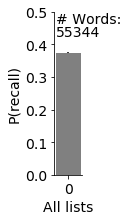

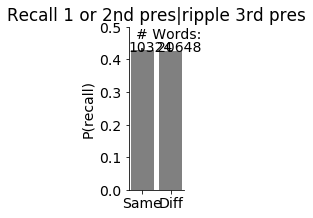

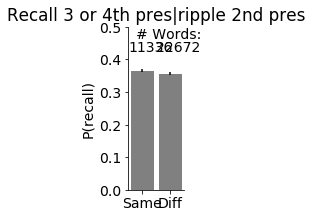

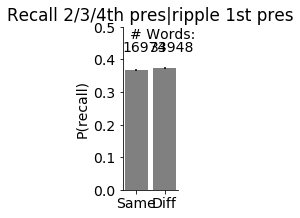

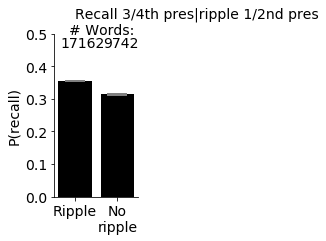

Ttest_indResult(statistic=6.627728707142935, pvalue=3.4733275401209574e-11)


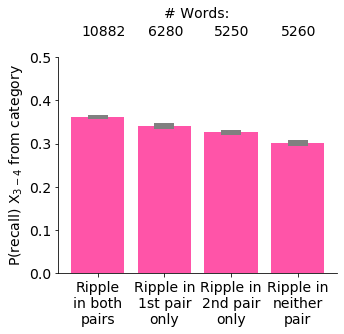

Ttest_indResult(statistic=2.8079456272445293, pvalue=0.004991492951309284)


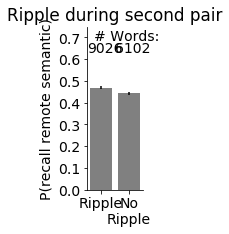

In [101]:
# plot each of these

save_plots = 1

figSub,axSub = plt.subplots(1,1, figsize=(0.5,3))
axSub.bar( 0, np.mean(word_correct_array), 
              yerr = seFromProp(sum(word_correct_array),len(word_correct_array)),color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1,1))
ylim(0,0.5)
ylabel('P(recall)')
xlabel('All lists')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.4,0.465,'# Words:')
text(-0.4,0.425,len(word_correct_array))


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_3_12_same),np.mean(cat_3_12_diff)], 
              yerr = [seFromProp(sum(cat_3_12_same),len(cat_3_12_same)),seFromProp(sum(cat_3_12_diff),len(cat_3_12_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_3_12_same))
text(0.5,0.425,len(cat_3_12_diff))
title('Recall 1 or 2nd pres|ripple 3rd pres')


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_2_34_same),np.mean(cat_2_34_diff)], 
              yerr = [seFromProp(sum(cat_2_34_same),len(cat_2_34_same)),seFromProp(sum(cat_3_12_diff),len(cat_3_12_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_2_34_same))
text(0.5,0.425,len(cat_2_34_diff))
title('Recall 3 or 4th pres|ripple 2nd pres')
# print(stats.ttest_ind(cat_2_34_same,cat_2_34_diff))


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_1_234_same),np.mean(cat_1_234_diff)], 
              yerr = [seFromProp(sum(cat_1_234_same),len(cat_1_234_same)),seFromProp(sum(cat_1_234_diff),len(cat_1_234_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_1_234_same))
text(0.5,0.425,len(cat_1_234_diff))
title('Recall 2/3/4th pres|ripple 1st pres')

figSub,axSub = plt.subplots(1,1, figsize=(1.5,3))
plot_color = (0,0,0); errorbar_color = (0.5,0.5,0.5)
axSub.bar( [0,1], [np.mean(cat_2_1_same),np.mean(cat_2_1_diff)], 
              yerr = [seFromProp(sum(cat_2_1_same),len(cat_2_1_same)),seFromProp(sum(cat_2_1_diff),len(cat_2_1_diff))],
                      color=plot_color,error_kw=dict(lw=20, capsize=0, capthick=0, ecolor=errorbar_color))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Ripple','No\nripple'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.15,0.5,'# Words:')
text(-0.35,0.46,len(cat_2_1_same))
text(0.65,0.46,len(cat_2_1_diff))
text(0,0.55,'Recall 3/4th pres|ripple 1/2nd pres'); show()
print(stats.ttest_ind(cat_2_1_same,cat_2_1_diff))


figSub,axSub = plt.subplots(1,1, figsize=(5,5))
plt.rcParams.update({'font.size': 14})
if location_selected == 'ca1':
    plot_color = (0,0.66,1); errorbar_color = (0.5,0.5,0.5)
else:
    plot_color = (1,0.33,0.66); errorbar_color = (0.5,0.5,0.5) 
axSub.bar( range(4), [np.mean(cat_12ripple_34corr),np.mean(cat_12ripple_34corr_ripple),
                   np.mean(cat_12NO_34_corr_ripple),np.mean(cat_12NO_34_corr_NO)], 
                  yerr = [seFromProp(sum(cat_12ripple_34corr),len(cat_12ripple_34corr)),
                          seFromProp(sum(cat_12ripple_34corr_ripple),len(cat_12ripple_34corr_ripple)),
                          seFromProp(sum(cat_12NO_34_corr_ripple),len(cat_12NO_34_corr_ripple)),
                          seFromProp(sum(cat_12NO_34_corr_NO),len(cat_12NO_34_corr_NO))],
                  color=plot_color,error_kw=dict(lw=20, capsize=0, capthick=0, ecolor=errorbar_color) )
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,3.01,1))
axSub.set_xticklabels(['Ripple\nin both\npairs','Ripple in\n1st pair\nonly',\
                       'Ripple in\n2nd pair\nonly','Ripple in\nneither\npair'],size=14)
ylim(0,0.5)
ylabel('P(recall) X$_{3-4}$ from category')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text_height = 0.55
text(1.0,text_height+0.04,'# Words:')
text(-0.25,text_height,len(cat_12ripple_34corr))
text(0.75,text_height,len(cat_12ripple_34corr_ripple))
text(1.75,text_height,len(cat_12NO_34_corr_ripple))
text(2.75,text_height,len(cat_12NO_34_corr_NO))
yticks(size=14)
plt.rcParams.update({'font.size': 14})
tight_layout()
if save_plots == 1:
    plt.savefig('../figures/conditionalRipplePlots/'+exp+'_'+'3rd-4th_category_recalls_by_ripples_'+region_name+'_'+location_selected+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
show()
print(stats.ttest_ind(cat_12ripple_34corr,cat_12ripple_34corr_ripple))




figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_12_34ripple_34),np.mean(cat_12_34noripple_34)], 
              yerr = [seFromProp(sum(cat_12_34ripple_34),len(cat_12_34ripple_34)),seFromProp(sum(cat_12_34noripple_34),len(cat_12_34noripple_34))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.701,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Ripple','No\nRipple'])
ylim(0,0.75)
ylabel('P(recall remote semantic)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.685,'# Words:')
text(-0.5,0.63,len(cat_12_34ripple_34))
text(0.5,0.63,len(cat_12_34noripple_34))
plt.title('Ripple during second pair')

# figSub,axSub = plt.subplots(1,1, figsize=(1,3))
# axSub.bar( [0,1], [np.mean(cat_12_34ripple_12),np.mean(cat_12_34noripple_12)], 
#               yerr = [seFromProp(sum(cat_12_34ripple_12),len(cat_12_34ripple_12)),seFromProp(sum(cat_12_34noripple_12),len(cat_12_34noripple_12))],
#                       color = (0.5,0.5,0.5))
# yticks(np.arange(0,0.701,0.1))
# xticks(np.arange(0,1.01,1))
# axSub.set_xticklabels(['Ripple','No \nRipple'])
# ylim(0,0.75)
# ylabel('P(recall 2nd pair|recalled 1st pair)')
# axSub.spines['top'].set_visible(False)
# axSub.spines['right'].set_visible(False)
# text(-0.24,0.685,'# Words:')
# text(-0.45,0.63,len(cat_12_34ripple_12))
# text(0.55,0.63,len(cat_12_34noripple_12))
# # plt.title('Ripple during first pair')

# figSub,axSub = plt.subplots(1,1, figsize=(1.75,3))
# axSub.bar( [0,1], np.array([np.mean(cat_12recall_34recall_Hz),np.mean(cat_12recall_34norecall_Hz)]), 
#               yerr = [np.std(cat_12recall_34recall_Hz)/np.sqrt(len(cat_12recall_34recall_Hz)),
#                       np.std(cat_12recall_34norecall_Hz)/np.sqrt(len(cat_12recall_34norecall_Hz))],
#                       color = (0.5,0.5,0.5))
# yticks(np.arange(0,0.501,0.1))
# xticks(np.arange(0,1.01,1))
# axSub.set_xticklabels(['Recalled\n2nd pair\nwords','Not\nrecalled\n2nd pair\nwords'])
# ylim(0,0.5)
# ylabel('Word presentation ripple rate (Hz)')
# axSub.spines['top'].set_visible(False)
# axSub.spines['right'].set_visible(False)
# text(0.0,0.435,'# Words:')
# text(-0.25,0.4,len(cat_12recall_34recall))
# text(0.75,0.4,len(cat_12recall_34norecall))
# plt.title('If recalled one of 1st pair')

a=1;

In [240]:
[seFromProp(sum(cat_12ripple_34corr),len(cat_12ripple_34corr)),
                          seFromProp(sum(cat_12ripple_34corr_ripple),len(cat_12ripple_34corr_ripple)),
                          seFromProp(sum(cat_12NO_34_corr_ripple),len(cat_12NO_34_corr_ripple)),
                          seFromProp(sum(cat_12NO_34_corr_NO),len(cat_12NO_34_corr_NO))]

[0.006725440268577421,
 0.00847235270787762,
 0.009141273867211164,
 0.008530773930948771]

In [239]:
# David's idea is more like this:
# If you see ripples on 3rd/4th trial, he expects greater recall on 3&4 v. 1/2

## just for 6th v. 7th presented words, to see if Category Presentation 1-2 has more ripples or it's just a decrease over encoding

done making binned start_array with shape:
(4330, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
done making binned start_array with shape:
(4268, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


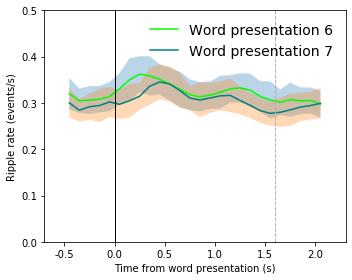

In [79]:
%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# subject_name_array and session_name_array are the same for all 4 

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = r6
        cat_subject_name_array = r6_sub_array
        cat_session_name_array = r6_sess_array
        
        # for plot
        subplots(1,1,figsize=(5,4))        
        plot_color = (0,1,0) #(1,0,0)
        label = 'Word presentation 6'
#         text(500,0.21,label,usetex=True,size=16,color=plot_color)
#         text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    elif category == 1:       
        temp_start_array = r7
        cat_subject_name_array = r7_sub_array
        cat_session_name_array = r7_sess_array
        
        plot_color = (0,0.5,0.5) #(0.75,0,0)
        label = 'Word presentation 7'
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SEs == 1:
        SE_plot = getMixedEffectSEs(binned_start_array,cat_subject_name_array,cat_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    if plot_SEs == 1:
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
leg = ax.legend(frameon=False,prop={'size': 14})
a=1;

# Regression section: test if list presentation number accounts for higher ripples for early categories

In [143]:
np.unique(word_presentation_serialpos)

median_serialpos = np.array(copy(word_presentation_serialpos))
for num in np.arange(2,7): # 1 is already right
    mask = (word_presentation_serialpos == num)
    median_serialpos[mask] = 1
for num in np.arange(7,13): 
    mask = (word_presentation_serialpos == num)
    median_serialpos[mask] = 2    

# put serialpositions into quartiles
quartile_serialpos = np.array(copy(word_presentation_serialpos))
for num in np.arange(2,4):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 1
for num in np.arange(4,7):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 2
for num in np.arange(7,10):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 3    
for num in np.arange(10,13):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 4 
np.unique(quartile_serialpos)

# put serialpositions into terciles
tercile_serialpos = np.array(copy(word_presentation_serialpos))
for num in np.arange(2,5):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 1
for num in np.arange(5,9):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 2
for num in np.arange(9,13):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 3   
np.unique(tercile_serialpos)

# split 4 category_presentations into 2 categories
if exp == 'catFR1':
    split_category_presentation = np.array(copy(category_presentation))
    for num in np.arange(0,2):
        mask = (category_presentation == num)
        split_category_presentation[mask] = 0
    for num in np.arange(2,4):
        mask = (category_presentation == num)
        split_category_presentation[mask] = 1 
    np.unique(split_category_presentation)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

array([1, 2, 3, 4])

array([1, 2, 3])

array([0, 1])

In [21]:
quartile_serialpos[0:50]
tercile_serialpos[0:50]
np.array(category_presentation[0:50])
split_category_presentation[0:50]

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
       4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 1, 1])

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 1, 1])

array([], dtype=float64)

NameError: name 'split_category_presentation' is not defined

In [35]:
np.mean(word_presentation_ripples)

0.5477175697865353

In [144]:
import statsmodels.formula.api as smf

_,counts = np.unique(category_presentation,return_counts=True)
print(counts)

if exp == 'catFR1':
    category_df = pd.DataFrame(data={'serialpos':word_presentation_serialpos, 'tercile_serialpos':tercile_serialpos, #word_presentation_serialpos
                                     'categories':split_category_presentation, #split_category_presentation,#category_presentation
                                     'ripple_rates':word_presentation_ripples,'median_serialpos':median_serialpos,
                                     'subject':regression_subject_name_array,'session':regression_session_name_array})
else:
    category_df = pd.DataFrame(data={'serialpos':word_presentation_serialpos, 'tercile_serialpos':tercile_serialpos, #word_presentation_serialpos
                                 'ripple_rates':word_presentation_ripples,'median_serialpos':median_serialpos,
                                 'subject':regression_subject_name_array,'session':regression_session_name_array})

vc = {'session':'0+session'}

# catFR models with categories
# get_bin_CI_model = smf.mixedlm("ripple_rates ~ C(tercile_serialpos)+C(categories)", category_df, groups="subject", vc_formula=vc)
# FR models with just serialpos
# get_bin_CI_model = smf.mixedlm("ripple_rates ~pos C(tercile_serial)", category_df, groups="subject", vc_formula=vc)
# get_bin_CI_model = smf.mixedlm("ripple_rates ~ serialpos", category_df, groups="subject", vc_formula=vc)
get_bin_CI_model = smf.mixedlm("ripple_rates ~ serialpos+median_serialpos", category_df, groups="subject", vc_formula=vc)

bin_model = get_bin_CI_model.fit(reml=True, method='nm',maxiter=5000)
bin_model.summary()
bin_model.pvalues

[8298 8298 8298 8298]


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM Dependent Variable: ripple_rates
No. Observations:  33192   Method:             REML        
No. Groups:        31      Scale:              0.7523      
Min. group size:   144     Likelihood:         -42481.1216 
Max. group size:   10500   Converged:          Yes         
Mean group size:   1070.7                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.695    0.031 22.092 0.000  0.633  0.756
serialpos         0.002    0.003  0.587 0.557 -0.004  0.007
median_serialpos -0.125    0.019 -6.500 0.000 -0.163 -0.087
session Var       0.043    0.009                           
===========================================================

"""

Intercept           3.795167e-108
serialpos            5.569925e-01
median_serialpos     8.055347e-11
session Var          1.907525e-07
dtype: float64

In [25]:
category_df
category_df.tercile_serialpos

,serialpos,tercile_serialpos,ripple_rates,subject,session
0,1,1,0,R1002P,R1002P-0
1,2,1,0,R1002P,R1002P-0
2,3,1,1,R1002P,R1002P-0
3,4,1,1,R1002P,R1002P-0
4,5,2,0,R1002P,R1002P-0
...,...,...,...,...,...
30445,8,2,0,R1342M,R1342M-0
30446,9,3,0,R1342M,R1342M-0
30447,10,3,0,R1342M,R1342M-0
30448,11,3,1,R1342M,R1342M-0


0        1
1        1
2        1
3        1
4        2
        ..
30445    2
30446    3
30447    3
30448    3
30449    3
Name: tercile_serialpos, Length: 30450, dtype: int64

## For whole_encoding analysis, for each patient find high and low ripple lists

In [73]:
def getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array):
    
    # take list of ripples per trial and output list of correct recall number for high and low ripple lists
    median_ripples = np.median(ripples_per_list)
    high_ripple_idxs = findInd(ripples_per_list > median_ripples)
    low_ripple_idxs = findInd(ripples_per_list <= median_ripples)        
    high_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(high_ripple_idxs)]) # recalls/list for sub's high ripple lists
    low_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(low_ripple_idxs)]) # same for low ripple lists
    
    return high_ripple,low_ripple

# kept encoding period long enough for 12*(1.6)+11*(1.0)=30.2 s

min_lists = 20

pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors
ISI_bin_start_end = [1700,2300]
sr_factor = 2 # downsampled ripples to 500 Hz.

encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
ISI_encoding_range = range(int((-pre_encoding_time+ISI_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ISI_bin_start_end[1])/sr_factor)) 

full_encoding_start_array = start_array[:,encoding_range] # remove 2 sec I added before alignment to first word
ISI_start_array = start_array[:,ISI_encoding_range]

print('Length of start_array: '+str(np.round(np.shape(full_encoding_start_array)[1]/1000*2,2)))
print('Length of ISI_start_array: '+str(np.round(np.shape(ISI_start_array)[1]/1000*2,2)))

sub_recalls_per_list = []

delta_ripple_correct = []
ISI_delta_ripple_correct = []
word_high_ripple_correct = []
word_low_ripple_correct = []
ISI_high_ripple_correct = []
ISI_low_ripple_correct = []

total_ISI_times = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) >= min_lists:
        sub_start_array = full_encoding_start_array[sub_idxs]
        sub_ISI_start_array = ISI_start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]
#         sub_list_recall_num_array = list_recall_num_array[sub_idxs] # whole_encoding variable I think
        sub_correct_array = word_correct_array[sub_idxs]
        sub_list_num_key = list_num_key[sub_idxs]
    
        # whole encoding splits
        
#         sub_recalls_per_list.append(np.mean(sub_list_recall_num_array)) # record overall recalls/list for sub       

#         # this gets you mean values across entirety of encoding period        
#         # 0.875 is average of 0.75-1.0 s and there are 11 ISIs, so this grabs 2.0:30.825 s (first 2 seconds were added for plots)
#         ripples_per_list = np.sum(sub_start_array[:,:int(1000+(1600*12/sr_factor)+(875*11/sr_factor))],1)
        
#         high_ripple,low_ripple = getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array)
#         high_ripple_correct.append(high_ripple)
#         low_ripple_correct.append(low_ripple)
        
        # now want to split up word presentation and ISI periods by ripple rate
        

        
        
# this block of code looks like it was written for some sort of list-level code version that went one list at a time

        word_ripples_per_word = []
        ISI_ripples_per_word = []
        sub_recalls_per_list = []
#         for trial_num in range(len(sub_start_array)):
#             word_ripple_list = []; 
#             ISI_ripple_list = []; 
#             ISI_times = [] # accumulating these as a check

#             word_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+offset_sr): 
#                                                         int(word_time/sr_factor+presentation_sr+offset_sr)]))
# #                 word_times.append( (word_time/sr_factor+presentation_sr+offset_sr) - (word_time/sr_factor+offset_sr) ) # these are always 1600 by definition
#             if i_word<len(sub_encoded_word_times[trial_num])-1: # last word doesn't have an ISI afterwards
#                 ISI_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+presentation_sr+offset_sr):
#                                                            int(sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr)]))
#                 ISI_times.append( (sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr) - (word_time/sr_factor+presentation_sr+offset_sr) )

                
            # now you have number of ripples in this trial for the 12 words and 11 ISIs
        for session in np.unique(sub_session_name_array):
            for list_num in np.unique(sub_list_num_key):
                session_list_idxs = (sub_session_name_array==session)&(sub_list_num_key==list_num)
                sess_list_trial_num = sum(session_list_idxs)
                
                if sess_list_trial_num > 0:
                    word_ripples_per_word.append(np.sum(sub_start_array[session_list_idxs])/sess_list_trial_num
                                                 /((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000))
                    ISI_ripples_per_word.append(np.sum(sub_ISI_start_array[session_list_idxs])/sess_list_trial_num
                                                 /((ISI_bin_start_end[1]-ISI_bin_start_end[0])/1000))
                    sub_recalls_per_list.append(12*np.sum(sub_correct_array[session_list_idxs])/sess_list_trial_num)
                
#         total_ISI_times.extend(ISI_times) # ISI times seem to be more like 900 ms than 875 ms...likely some lag
        # now have ripple rates for each trial for both words and ISIs
        high_ripple,low_ripple = getHighLowRecallFromRipples(word_ripples_per_word,sub_recalls_per_list)
        delta_ripple_correct.append(high_ripple-low_ripple)
        word_high_ripple_correct.append(high_ripple)
        word_low_ripple_correct.append(low_ripple)        
        high_ripple,low_ripple = getHighLowRecallFromRipples(ISI_ripples_per_word,sub_recalls_per_list)
        ISI_delta_ripple_correct.append(high_ripple-low_ripple)
        ISI_high_ripple_correct.append(high_ripple)
        ISI_low_ripple_correct.append(low_ripple)           
        
a=1;

Length of start_array: 1.6
Length of ISI_start_array: 0.6


1-sample t-tests:
Whole retrieval: p=nan, t=nan
Word presentations: p=0.507, t=-0.67
ISI: p=0.015, t=-2.57


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


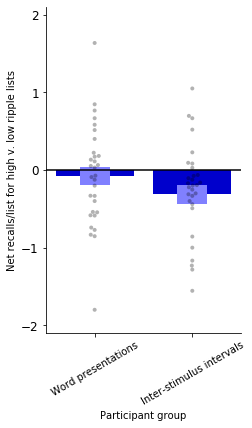

In [78]:
## high v. low recall patients

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'

high_low_diffs = np.concatenate(( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct),
                                  np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) ))
# high_low_diffs = np.concatenate(( high_low_diffs, np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) ))
    
plot_df = pd.DataFrame({'high_low_diffs':high_low_diffs,
                        'idxs':np.concatenate(( np.zeros(len(high_ripple_correct)),np.ones(len(word_high_ripple_correct)), 
                                                2*np.ones(len(ISI_high_ripple_correct)) ))
                        })

mean_correct = [np.mean( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) ),
                np.mean( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )] #,
#                 np.mean( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )]
ste_correct = [np.std( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) )/np.sqrt(len(word_high_ripple_correct)),
                np.std( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )/np.sqrt(len(ISI_high_ripple_correct))] #,
#                 np.std( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )/np.sqrt(len(ISI_high_ripple_correct))]

figSub,axSub = plt.subplots(1,1, figsize=(3.5,6))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
plot([-1,5],[0,0],color='k')
bar(range(2),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

extra = '_swarm'
p1 = sb.swarmplot(x='idxs',y='high_low_diffs',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
axSub.set(ylim=(-2.1,2.1))
ytick_range = np.arange(-2,2.01)
ylabel(u'Net recalls/list for high v. low ripple lists')

    
t_p0 = stats.ttest_1samp(np.array(high_ripple_correct)-np.array(low_ripple_correct),0)
t_p1 = stats.ttest_1samp(np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct),0)
t_p2 = stats.ttest_1samp(np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct),0)
print('1-sample t-tests:')
print('Whole retrieval: p='+str(np.round(t_p0[1],3))+', t='+str(np.round(t_p0[0],2)))    
print('Word presentations: p='+str(np.round(t_p1[1],3))+', t='+str(np.round(t_p1[0],2)))    
print('ISI: p='+str(np.round(t_p2[1],3))+', t='+str(np.round(t_p2[0],2)))    
    
yticks(ytick_range,fontsize=12)
xticks(range(2),['Word presentations','Inter-stimulus intervals'],fontsize=10,rotation=30) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')

# # check out accuracy rates v. subjects
# print('Whole retrieval period:')
# print(high_low_diffs)
# print(np.unique(subject_name_array))



a=1;

## Big Raster!!

NameError: name 'channel_nums_array' is not defined

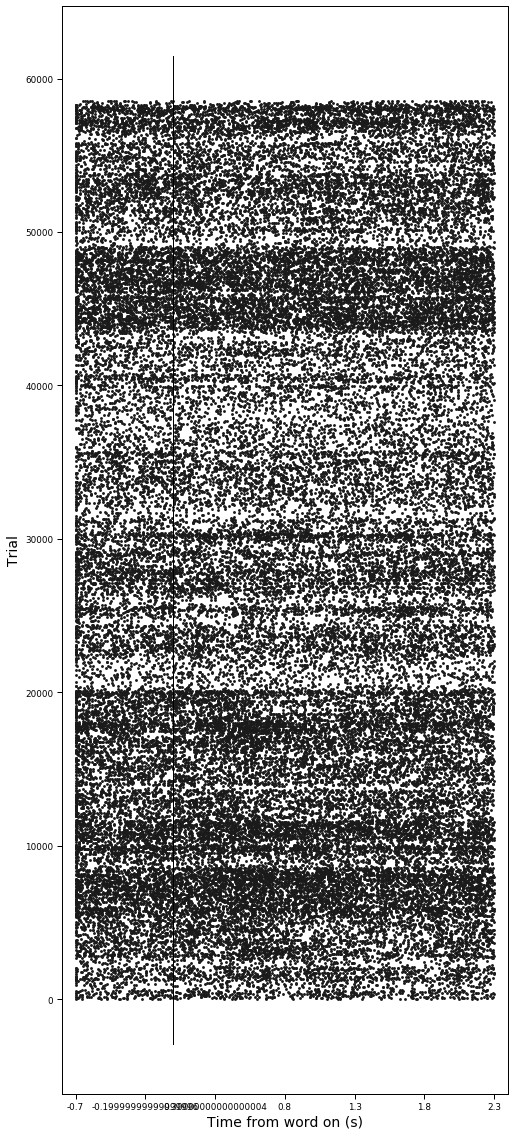

In [81]:
## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

%autoreload

elec_dividers_on = 0 # toggles light gray lines between electrodes
session_dividers_on = 0

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6)
between_session_color = (0,0.6,0.6)

# encoding_whole_time = 1000*np.round(12*(1.6+0.875),1)

if selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time #2000
    
raster_width = 8
raster_height = 20 #0 #10 # 40

# plot raster
subplots(1,1,figsize=(raster_width,raster_height))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from word presentation (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
# plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

# SCEs by serialpos

## let's create adjacent+semantic and unclustered+dead end 

In [15]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors

# 0 is adjacent_semantic, 1 is remote_semantic, 2 is remote unclustered, 3 is dead end

# saving it this way so I can use eval() below
start_array0 = []; start_array1 = []; start_array2 = []; start_array3 = []
sub_name_array0 = []; sess_name_array0 = []; serialpos0 = []
sub_name_array1 = []; sess_name_array1 = []; serialpos1 = []
sub_name_array2 = []; sess_name_array2 = []; serialpos2 = []
sub_name_array3 = []; sess_name_array3 = []; serialpos3 = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            list_ch_serialpos = serialpos_array[list_ch_idxs]

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                
                recall_position = list_ch_recall_positions[0][i_recall_type]
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    if recall_type == 'A': # adjacent semantic
                        # note the -1 since recall positions are on scale of 1-12
                        start_array0 = superVstack(start_array0,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                        serialpos0.append(list_ch_serialpos[recall_position-1])
                    elif recall_type == 'C': # remote semantic
                        start_array1 = superVstack(start_array1,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                        serialpos1.append(list_ch_serialpos[recall_position-1])                        
                    elif ( (recall_type == 'D') & (recall_position>0) ): # remote unclustered
                        start_array2 = superVstack(start_array2,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)                    
                        serialpos2.append(list_ch_serialpos[recall_position-1])                        
                    elif ( (recall_type == 'Z') & (recall_position>0) ): # last word of list & was actually a recalled word
                        start_array3 = superVstack(start_array3,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        serialpos3.append(list_ch_serialpos[recall_position-1])                        
            test=1

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


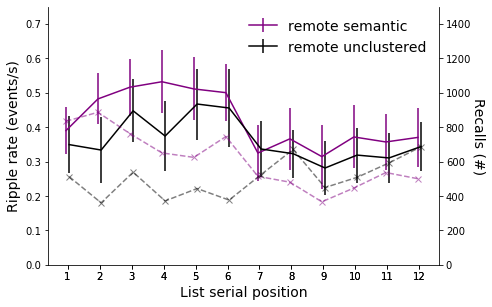

In [21]:
## plot recalled events by serial position

plot_two = [1,2]  # [1,3] # [0,2]
# 0 is adjacent_semantic, 1 is remote_semantic, 2 is remote unclustered, 3 is dead end

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]
sr_factor = 2 # since set ripples to 500 Hz resolution
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) )) # already accounted for sr_factor to get to 100 ms bin temp_array

# will plot each in this loop
for SME_type in plot_two:
    
    temp_start_array = eval('start_array'+str(SME_type)) # hence the 0-3 naming
    serialpos_array = np.array(eval('serialpos'+str(SME_type)))
    
    rates = [] 
    stds = []
    num_recalled = []
    for list_num in range(12):

        temp_start_array_sp = temp_start_array[serialpos_array==(list_num+1)]
        temp_start_array_sp = binBinaryArray(temp_start_array_sp,bin_size,sr_factor)

        # save data for full serial position plot below
        rates.append(np.mean(temp_start_array_sp[:,bin_test_range]))
        stds.append(np.std(temp_start_array_sp[:,bin_test_range])/np.sqrt(len(temp_start_array_sp)))
        num_recalled.append(temp_start_array_sp.shape[0])
        
    # plot'm both
    
    if SME_type == 0:
        label = 'List words lead to \\textbf{adjacent semantic}'
    elif SME_type == 1:
        label = 'List words lead to \\textbf{remote semantic}'
    elif SME_type == 2:
        label = 'List words lead to \\textbf{remote unclustered}'
    elif SME_type == 3:
        label = 'List words lead to \\textbf{dead end}'

    if SME_type == plot_two[0]:
        fig1 = figure(figsize=(7,4.75))
        offset = -0.05
        if location_selected == 'ca1':
            plot_color = (0,0,1)
        elif location_selected == 'dg':
            plot_color = (1,0,0)
        elif region_name == 'AMY':
            plot_color = (0.2,0.5,0)
        elif region_name == 'ENTPHC':
            plot_color = (0.5,0.2,0)
        else:
            plot_color = (0.5,0,0.5) # for ca1&dg
    else:
        plot_color = (0,0,0)
        offset = 0.05
    ax1 = fig1.add_subplot(111)
    xr=np.arange(1,13)
    line1 = errorbar(xr+offset,rates,stds,color=plot_color,label=label) 
    ylabel('Ripple rate (events/s)',size=14)
    
    # now, the second axes that shares the x-axis with the ax1
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line3 = ax2.plot(xr+offset,num_recalled,'xr--',color=plot_color,alpha=0.5)

xticks(xr,xr)
ax1.set_ylim(0,0.75)
xlabel('List serial position',size=14)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
if ((location_selected == 'ca1') | (location_selected == 'dg')):
    ax2.set_ylim(0,1000)
else:
    ax2.set_ylim(0,1500)    
ylabel("Recalls (#)",rotation=270,size=14)
ax2.yaxis.set_label_coords(1.12,0.5)

ax1.legend(frameon=False,fontsize=14,loc='upper right')
# if (exp == 'catFR1'):
#     ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
# else:
#     ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
ax1.spines['top'].set_visible(False)   
show();

## temporal SCEs by serialpos

In [117]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors

# 0 is adjacent temporal (lag = 1)
# 1 is remote remporal (lag ≥ 4)
# 2 is chaining  (-995 is code I used for recalls where people start at 1 and go 1->2->3->etc.)
# 3 is dead ends
 
start_array0 = []; start_array1 = []; start_array2 = []; start_array3 = []
sub_name_array0 = []; sess_name_array0 = []; serialpos0 = []
sub_name_array1 = []; sess_name_array1 = []; serialpos1 = []
sub_name_array2 = []; sess_name_array2 = []; serialpos2 = []
sub_name_array3 = []; sess_name_array3 = []; serialpos3 = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_temporal_key = temporal_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]

            for i_recall_type,recall_type in enumerate(list_ch_temporal_key[0]): # all 12 words have same values so just take 1st one
                
                recall_position = list_ch_recall_positions[0][i_recall_type]
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    ## select your adjacent temporal type here!! ##
                    
#                     if ((np.abs(recall_type) == 1)): # don't include chaining with adjacent temporal
                    if ((np.abs(recall_type) == 1) or (recall_type == -995)): # include chaining with adjacent temporal
                        # note the -1 since recall positions are on scale of 1-12
                        start_array0 = superVstack(start_array0,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                        serialpos0.append(list_ch_serialpos[recall_position-1])
                    elif ( (np.abs(recall_type) >= 4) & (np.abs(recall_type)<12) ): # remote temporal; ≥4 (lag=4) matches adjacent temporal better (remember these are lags so max is 11)
                        start_array1 = superVstack(start_array1,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                        serialpos1.append(list_ch_serialpos[recall_position-1])
                    elif recall_type == -995: # chaining only # note that if you include these above you'll get no trials for this!                        
                        start_array2 = superVstack(start_array2,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)                    
                        serialpos2.append(list_ch_serialpos[recall_position-1])
                    elif i_recall_type==(len(list_ch_temporal_key[0])-1): # last word of list (I checked it's always a 0 so can ignore recall_type)
                        start_array3 = superVstack(start_array3,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        serialpos3.append(list_ch_serialpos[recall_position-1])
            test=1

Number of List words lead to \textbf{adjacent temporal}
3476


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Number of List words lead to \textbf{dead end}
2739


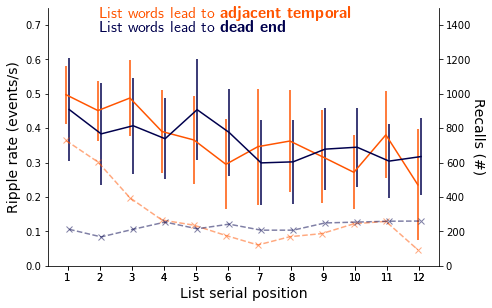

In [118]:
save_fig = 0
plot_SE = 1

# get PSTH for two of the types
plot_two = [0,3]  # [1,3] # [2,0] # [0,3]
# 0 is adjacent_temporal, 1 is remote_temporal, 2 is chaining, 3 is dead end

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]
sr_factor = 2 # since set ripples to 500 Hz resolution
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) )) # already accounted for sr_factor to get to 100 ms bin temp_array


# will plot each in this loop
for SME_type in plot_two:
    
    temp_start_array = eval('start_array'+str(SME_type)) # hence the 0-3 naming
    serialpos_array = np.array(eval('serialpos'+str(SME_type)))
    max_serialpos = np.max(serialpos_array) # since chaining never goes past 1,2,3,4,5 need to account for that
    
    rates = [] 
    stds = []
    num_recalled = []
    for list_num in range(max_serialpos):

        temp_start_array_sp = temp_start_array[serialpos_array==(list_num+1)]
        temp_start_array_sp = binBinaryArray(temp_start_array_sp,bin_size,sr_factor)

        # save data for full serial position plot below
        rates.append(np.mean(temp_start_array_sp[:,bin_test_range]))
        stds.append(np.std(temp_start_array_sp[:,bin_test_range])/np.sqrt(len(temp_start_array_sp)))
        num_recalled.append(temp_start_array_sp.shape[0])
        
    # plot'm both
    
    if SME_type == 0:        
        label = 'List words lead to \\textbf{adjacent temporal}'
        plot_color = (1,0.33,0)   
    elif SME_type == 1:
        label = 'List words lead to \\textbf{remote temporal}'
        plot_color = (0,0.66,1)
    elif SME_type == 2:
        label = 'List words lead to \\textbf{chaining}'
        plot_color = (0,0.3,0)
    elif SME_type == 3:
        label = 'List words lead to \\textbf{dead end}'
        plot_color = (0,0,0.3)     
            
    if SME_type == plot_two[0]:
        fig1 = figure(figsize=(7,4.75))
        offset = -0.05       
    else:
        if SME_type==2: # if comparing to chaining
            label = 'Remaining \\textbf{adjacent temporal}'
            plot_color = (0,0,0)               
        offset = 0.05        

    ax1 = fig1.add_subplot(111)
    xr=np.arange(1,max_serialpos+1)
    line1 = errorbar(xr+offset,rates,stds,color=plot_color) 
    ylabel('Ripple rate (events/s)',size=14)
    if SME_type == plot_two[0]:
        # for plot   
        text(2,0.72,label,usetex=True,size=16,color=plot_color) 
    else:
        text(2,0.68,label,usetex=True,size=16,color=plot_color)     
    
    # now, the second axes that shares the x-axis with the ax1
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line3 = ax2.plot(xr+offset,num_recalled,'xr--',color=plot_color,alpha=0.5)
    print('Number of '+label)
    print(len(temp_start_array))

xticks(xr,xr)
ax1.set_ylim(0,0.75)
xlabel('List serial position',size=14)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
if ((location_selected == 'ca1') | (location_selected == 'dg')):
    ax2.set_ylim(0,1000)
else:
    ax2.set_ylim(0,1500)    
ylabel("Recalls (#)",rotation=270,size=14)
ax2.yaxis.set_label_coords(1.12,0.5)

# ax1.legend(frameon=False,fontsize=14,loc='upper right')
# if (exp == 'catFR1'):
#     ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
# else:
#     ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
ax1.spines['top'].set_visible(False)   
show();

## Make serialpos curve conditional on if ripple occurred in given serialpos (or group of serialpos)

In [54]:
bin_test_range

range(8, 24)

Number in each bin: 3558


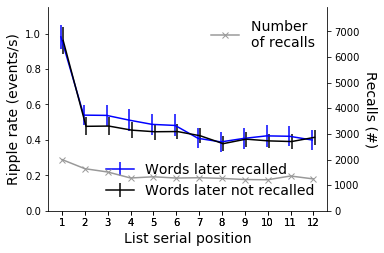

Number in each bin: 3480


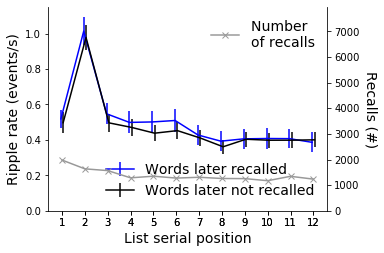

Number in each bin: 3494


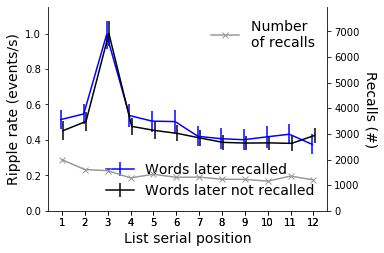

Number in each bin: 3452


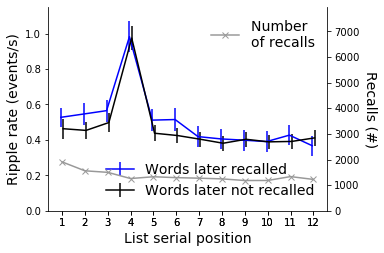

Number in each bin: 3474


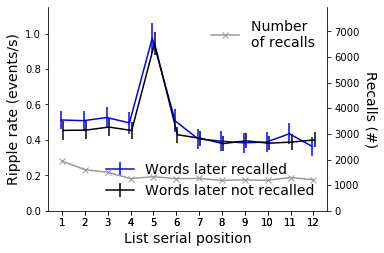

Number in each bin: 3407


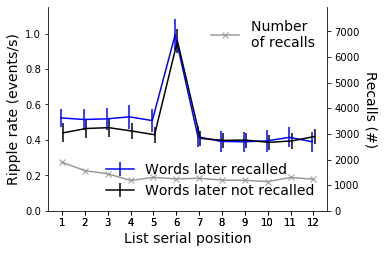

In [53]:
## plot recalled events by serial position

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]
sr_factor = 2 # since set ripples to 500 Hz resolution
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) )) # already accounted for sr_factor to get to 100 ms bin temp_array
# same thing but at ms level
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
word_pres_start_array = start_array[:,encoding_range]

# make serialpos curves contingent on ripple in cat 1, cat 2, or cat 3
for cat_ripple in range(6): #[0,2,4]:
    
    cat_ripple_indicator = []
    new_serialpos_array = []; new_word_correct_array = []; new_start_array = []
    # need to define this variable for each list so can define list by if ripple during this category pres 1/2 exists

    for sess in np.unique(session_name_array):
        sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        for ln in sess_list_nums:
            list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
            for elec in list_elec_array:
                list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
                temp_encoding_array = word_pres_start_array[list_ch_idxs]
                temp_wc_array = word_correct_array[list_ch_idxs]

                num_trials = sum(list_ch_idxs)
#                 if sum(temp_encoding_array[cat_ripple:cat_ripple+2,:])>0: # if doing every 2                
                if sum(temp_encoding_array[cat_ripple,:])>0: # if doing every 1  
                    cat_ripple_indicator.extend(np.ones(num_trials)) # for each list define indicator of 12 1s if ripple in cat pres 1/2
                else:
                    cat_ripple_indicator.extend(np.zeros(num_trials))
                # remake these to make sure they're in same order
                new_serialpos_array.extend(np.arange(1,num_trials+1))
                new_word_correct_array.extend(temp_wc_array)
                new_start_array = superVstack(new_start_array,start_array[list_ch_idxs])
                
    ct = 0
    serial_position_rem_rates = []
    serial_position_rem_stds = []
    serial_position_forgot_rates = []
    serial_position_forgot_stds = []
    num_recalled = []; num_forgot = []
    new_word_correct_array = np.array(new_word_correct_array); new_serialpos_array = np.array(new_serialpos_array)
    cat_ripple_indicator = np.array(cat_ripple_indicator)

    for list_num in range(12):

        temp_start_array_rem = new_start_array[(new_word_correct_array==1) & (new_serialpos_array==(list_num+1)) \
                                           & (cat_ripple_indicator==1)]
        temp_start_array_forgot = new_start_array[(new_word_correct_array==0) & (new_serialpos_array==(list_num+1)) \
                                              & (cat_ripple_indicator==1)]

        temp_array_rem = binBinaryArray(temp_start_array_rem,bin_size,sr_factor)
        temp_array_forgot = binBinaryArray(temp_start_array_forgot,bin_size,sr_factor)

        # save data for full serial position plot below
        serial_position_rem_rates.append(np.mean(temp_array_rem[:,bin_test_range]))
        serial_position_rem_stds.append(np.std(temp_array_rem[:,bin_test_range])/np.sqrt(len(temp_array_rem)))
        serial_position_forgot_rates.append(np.mean(temp_array_forgot[:,bin_test_range]))
        serial_position_forgot_stds.append(np.std(temp_array_forgot[:,bin_test_range])/np.sqrt(len(temp_array_forgot)))
        num_recalled.append(temp_array_rem.shape[0])
        num_forgot.append(temp_array_forgot.shape[0])   
    a=1;

    # create the general figure
    fig1 = figure(figsize=(5,3.75))

    # and the first axes using subplot populated with data 
    ax1 = fig1.add_subplot(111)

    xr=np.arange(1,13)

    if location_selected == 'ca1':
        plot_color = (0,0,1)
    elif location_selected == 'dg':
        plot_color = (1,0,0)
    elif region_name == 'AMY':
        plot_color = (0.2,0.5,0)
    elif region_name == 'ENTPHC':
        plot_color = (0.5,0.2,0)

    line1 = errorbar(xr-0.05,serial_position_rem_rates,serial_position_rem_stds,color=plot_color) 
    line2 = errorbar(xr+0.05,serial_position_forgot_rates,serial_position_forgot_stds,color=(0,0,0))
    xticks(xr,xr)
    ax1.set_ylim(0,1.15)
    xlabel('List serial position',size=14)
    ylabel('Ripple rate (events/s)',size=14)

    # now, the second axes that shares the x-axis with the ax1
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line3 = ax2.plot(xr,num_recalled, 'xr-',color=(0.6,0.6,0.6))
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    if location_selected == 'ca1':
        ax2.set_ylim(0,7950) #2500)
    elif location_selected == 'dg':
        ax2.set_ylim(0,5400)    
    ylabel("Recalls (#)",rotation=270,size=14)
    ax2.yaxis.set_label_coords(1.18,0.5)

    ax1.legend((line1,line2),("Words later recalled","Words later not recalled"),frameon=False,fontsize=14,loc='lower right')
    if (exp == 'catFR1'):
        ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
    else:
        ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

    # for the legend, remember that we used two different axes so, we need 
    # to build the legend manually
    # legend((line1, line2), ("1", "2"))
    ax1.spines['top'].set_visible(False)   
    print('Number in each bin: '+str(len(temp_array_rem)+len(temp_array_forgot)))
    show();
a=1;

# If we load ripples from retrieval, what can we say about how encoding ripples lead to retrieval ripples+recalls? (come here after get start_array)


In [81]:
# load your retrieval period dataframe 

if location_selected == ['ca1', 'dg']:
    # combine them
    temp3 = pd.read_csv('/home1/john/SWR/compiled/ripple_retrieval_catFR1_'+location_selected[0]+'_df.csv')
    temp4 = pd.read_csv('/home1/john/SWR/compiled/ripple_retrieval_catFR1_'+location_selected[1]+'_df.csv')
    ripple_retrieval_df_ca1 = temp3.append(temp4)
    
    temp1 = pd.read_csv('/home1/john/SWR/compiled/retrieval_catFR1_'+location_selected[0]+'_df.csv') 
    temp2 = pd.read_csv('/home1/john/SWR/compiled/retrieval_catFR1_'+location_selected[1]+'_df.csv')
    retrieval_df_ca1 = temp1.append(temp2)
    
else: # for single subfields:
    ripple_retrieval_df_ca1 = pd.read_csv('/home1/john/SWR/compiled/ripple_retrieval_catFR1_'+location_selected+'_df.csv')
    retrieval_df_ca1 = pd.read_csv('/home1/john/SWR/compiled/retrieval_catFR1_'+location_selected+'_df.csv') 
    
len(ripple_retrieval_df_ca1)
ripple_retrieval_df_ca1[0:15]    
len(retrieval_df_ca1)
retrieval_df_ca1[0:15]

46550

,ripple_time,subject,session,list,word,category,semantic_clustering_key,recall_position,serialpos,electrode,mstime
0,-1086,R1004D,0,1,SPARROW,Birds,Z,1,6,LOTD2-LOTD3,1.415723e+12
1,1506,R1004D,0,2,BEAR,Zoo,Z,2,7,LOTD2-LOTD3,1.415723e+12
2,-1344,R1004D,0,6,CHEESECAKE,Desserts,A,1,1,LOTD2-LOTD3,1.415724e+12
3,1040,R1004D,0,6,CAKE,Desserts,C,2,2,LOTD2-LOTD3,1.415724e+12
4,-1316,R1004D,0,6,PIE,Desserts,Z,3,9,LOTD2-LOTD3,1.415724e+12
5,-130,R1004D,0,6,PIE,Desserts,Z,3,9,LOTD2-LOTD3,1.415724e+12
6,-1024,R1004D,0,9,SPIDER,Insects,D,1,1,LOTD2-LOTD3,1.415724e+12
7,6,R1004D,0,9,COBBLER,Desserts,Z,2,5,LOTD2-LOTD3,1.415724e+12
8,1680,R1004D,0,9,COBBLER,Desserts,Z,2,5,LOTD2-LOTD3,1.415724e+12
9,-922,R1004D,0,13,CYPRESS,Trees,Z,1,1,LOTD2-LOTD3,1.415725e+12


35743

,subject,session,list,word,category,semantic_clustering_key,recall_position,serialpos,electrode,mstime
0,R1004D,0,1,SPARROW,Birds,Z,1,6,LOTD2-LOTD3,1.415723e+12
1,R1004D,0,2,GIRAFFE,Zoo,C,1,1,LOTD2-LOTD3,1.415723e+12
2,R1004D,0,2,BEAR,Zoo,Z,2,7,LOTD2-LOTD3,1.415723e+12
3,R1004D,0,6,CHEESECAKE,Desserts,A,1,1,LOTD2-LOTD3,1.415724e+12
4,R1004D,0,6,CAKE,Desserts,C,2,2,LOTD2-LOTD3,1.415724e+12
5,R1004D,0,6,PIE,Desserts,Z,3,9,LOTD2-LOTD3,1.415724e+12
6,R1004D,0,9,SPIDER,Insects,D,1,1,LOTD2-LOTD3,1.415724e+12
7,R1004D,0,9,COBBLER,Desserts,Z,2,5,LOTD2-LOTD3,1.415724e+12
8,R1004D,0,12,JEANS,Clothing,I,1,1,LOTD2-LOTD3,1.415724e+12
9,R1004D,0,13,CYPRESS,Trees,Z,1,1,LOTD2-LOTD3,1.415725e+12


In [82]:
# theory is for key SCE recalls, will have encoding+retrieval ripple

# find adjacent semantic or remote semantic with ripples

# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

# these values are all for subject-level SCE v. avg_recalls analysis
# min_SCE_trials = 10 # minimum SCE trials in session to include in SCE v. avg_recalls plot

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors
sr_factor = 2 # downsampled ripples to 500 Hz.
PRE_start_end = range(-1100,-100)

stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding 
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
# comes to 400:1200 for 100 to 1700 of 1500 len timeseries

clustered_enc_ct = [] # vector indicating if ripple occured during subseqently semantic clustered word
clustered_ret_ct = [] # vector indicating if ripple in PRE for same word
unclustered_enc_ct = [] # vector indicating if ripple occurred during subsequently unclustered recall
unclustered_ret_ct = [] # vector indicating if ripple in PRE for same word

clustered_sub_ct = [] # for ME model
clustered_sess_ct = []
unclustered_sub_ct = []
unclustered_sess_ct = []

encoding_ripple_number = []
subsequent_IRT_time = []
IRT_sess = []
IRT_sub = []
IRT_clustering = []


session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess]) 
    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs][:,encoding_range]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                
                recall_serialpos = list_ch_recall_positions[0][i_recall_type]
                
                if recall_serialpos in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)
                    
#                     if recall_type == 'A': # adjacent semantic
                    if recall_type in ['A','C']: # adjacent AND remote semantic
                        # check if there's a ripple:
            
                        # note subtracting 1 since recall positions are on scale of 1-12
                        if sum(list_ch_encoding_array[recall_serialpos-1])>0:
                            clustered_enc_ct.append(1)
                        else:
                            clustered_enc_ct.append(0)
                        clustered_sub_ct.append(sess[0:6])
                        clustered_sess_ct.append(sess)
                            
                        # now check same for retrieval PRE
                        selected_recall_df = ripple_retrieval_df_ca1[
                            (ripple_retrieval_df_ca1.subject == sess[0:6]) & \
                            (ripple_retrieval_df_ca1.session == int(sess[7:])) & \
                            (ripple_retrieval_df_ca1.electrode == elec) & \
                            (ripple_retrieval_df_ca1.list == ln) & \
                            (ripple_retrieval_df_ca1.serialpos == recall_serialpos)
                            ]

                        # now have df for this elec so see if ripple exists for this recall in PRE window
                        if len(selected_recall_df)>0: # gotta do it this way in case multiple ripples in df
                            if sum([v in PRE_start_end for v in selected_recall_df.ripple_time.values])>0:
#                                 import ipdb; ipdb.set_trace()
                                clustered_ret_ct.append(1)
                            else:
                                clustered_ret_ct.append(0)
                        else:
                            clustered_ret_ct.append(0)
                            
                    elif recall_type in ['D','Z']: # remote unclustered AND dead ends
                        
                        # note the -1 since recall positions are on scale of 1-12
                        if sum(list_ch_encoding_array[recall_serialpos-1])>0:
                            unclustered_enc_ct.append(1)
                        else:
                            unclustered_enc_ct.append(0)
                        unclustered_sub_ct.append(sess[0:6])
                        unclustered_sess_ct.append(sess)                            
                            
                        # now check same for retrieval PRE
                        selected_recall_df = ripple_retrieval_df_ca1[
                            (ripple_retrieval_df_ca1.subject == sess[0:6]) & \
                            (ripple_retrieval_df_ca1.session == int(sess[7:])) & \
                            (ripple_retrieval_df_ca1.electrode == elec) & \
                            (ripple_retrieval_df_ca1.list == ln) & \
                            (ripple_retrieval_df_ca1.serialpos == recall_serialpos)
                            ]
                        
                        # now have df for this elec so see if ripple exists for this recall in PRE window
                        if len(selected_recall_df)>0: # gotta do it this way in case multiple ripples in df
                            if sum([v in PRE_start_end for v in selected_recall_df.ripple_time.values])>0:
                                unclustered_ret_ct.append(1)
                            else:
                                unclustered_ret_ct.append(0)
                        else:
                            unclustered_ret_ct.append(0)   
                            
                    # get the ripple rate for an encoding word if there is an IRT for the subsequent recall (i.e. isn't a dead end)
                    
                    # NOTICE THIS IS **NOT** THE RIPPLE DF...it's just a df of every recall
                    selected_recall_df = retrieval_df_ca1[
                        (retrieval_df_ca1.subject == sess[0:6]) & \
                        (retrieval_df_ca1.session == int(sess[7:])) & \
                        (retrieval_df_ca1.electrode == elec) & \
                        (retrieval_df_ca1.list == ln)
                        ]
                    if i_recall_type<(len(selected_recall_df)-1): # if IRT exists
                        encoding_ripple_number.append(sum(list_ch_encoding_array[recall_serialpos-1]))
                        subsequent_IRT_time.append(selected_recall_df.iloc[i_recall_type+1].mstime-selected_recall_df.iloc[i_recall_type].mstime)
                        IRT_sub.append(sess[0:6])
                        IRT_sess.append(int(sess[7:]))
                        IRT_clustering.append(recall_type)
                
a=1;

In [86]:
import statsmodels.formula.api as smf
plot_df = pd.DataFrame({'clustered':np.append(np.ones(len(clustered_enc_ct)),np.zeros(len(unclustered_enc_ct))),
                        'encoding_ripples':np.append(clustered_enc_ct,unclustered_enc_ct),
                        'PRE_ripples':np.append(clustered_ret_ct,unclustered_ret_ct),
                        'session':np.append(clustered_sess_ct,unclustered_sess_ct),
                        'subject':np.append(clustered_sub_ct,unclustered_sub_ct)
                        })

# model of IRTs for 0 vs. ≥1 ripple
vc = {'session':'0+session'} # to nest sessions in subjects
if location_selected == 'ca1':
    rr_model = smf.mixedlm("clustered~encoding_ripples*PRE_ripples",
                           plot_df, groups="subject", vc_formula=vc,re_formula="~encoding_ripples*PRE_ripples")     
else:
    rr_model = smf.mixedlm("clustered~encoding_ripples*PRE_ripples",
                           plot_df, groups="subject", vc_formula=vc,re_formula="~encoding_ripples+PRE_ripples") 
rr_fit = rr_model.fit(reml=True,maxiter=2000,method='nm')
print(rr_fit.summary())
print(rr_fit.pvalues)
print(rr_fit.params)
print(rr_fit.bse_fe)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             clustered  
No. Observations:              32874               Method:                         REML       
No. Groups:                    89                  Scale:                          0.2386     
Min. group size:               12                  Likelihood:                     -23260.7271
Max. group size:               6613                Converged:                      Yes        
Mean group size:               369.4                                                          
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.484    0.013 38.025 0.00

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


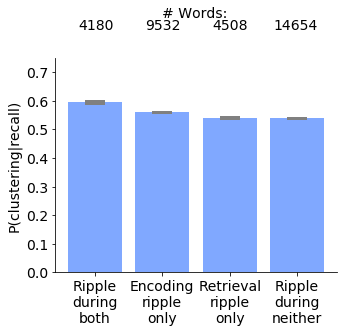

In [87]:
save_plots = 1

plot_df
clust_both = plot_df.clustered[plot_df.query('encoding_ripples == 1 and PRE_ripples == 1').index].values
clust_enc_only = plot_df.clustered[plot_df.query('encoding_ripples == 1 and PRE_ripples == 0').index].values
clust_ret_only = plot_df.clustered[plot_df.query('encoding_ripples == 0 and PRE_ripples == 1').index].values
clust_neither = plot_df.clustered[plot_df.query('encoding_ripples == 0 and PRE_ripples == 0').index].values

figSub,axSub = plt.subplots(1,1, figsize=(5,5))
plt.rcParams.update({'font.size': 14})
if location_selected == 'ca1':
    plot_color = (0.5,0.66,1); errorbar_color = (0.5,0.5,0.5)
else:
    plot_color = (1,0,0.33); errorbar_color = (0.5,0.5,0.5) 
axSub.bar( range(4), [np.mean(clust_both),np.mean(clust_enc_only),
                   np.mean(clust_ret_only),np.mean(clust_neither)], 
                  yerr = [seFromProp(sum(clust_both),len(clust_both)),
                          seFromProp(sum(clust_enc_only),len(clust_enc_only)),
                          seFromProp(sum(clust_ret_only),len(clust_ret_only)),
                          seFromProp(sum(clust_neither),len(clust_neither))],
                  color=plot_color,error_kw=dict(lw=20, capsize=0, capthick=0, ecolor=errorbar_color) )
yticks(np.arange(0,0.7501,0.1))
xticks(np.arange(0,3.01,1))
axSub.set_xticklabels(['Ripple\nduring\nboth','Encoding\nripple\nonly',\
                       'Retrieval\nripple\nonly','Ripple\nduring\nneither'],size=14)
ylim(0,0.75)
ylabel('P(clustering|recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text_height = 0.85
text(1.0,text_height+0.04,'# Words:')
text(-0.25,text_height,len(clust_both))
text(0.75,text_height,len(clust_enc_only))
text(1.75,text_height,len(clust_ret_only))
text(2.65,text_height,len(clust_neither))
yticks(size=14)
plt.rcParams.update({'font.size': 14})
tight_layout()
if save_plots == 1:
    plt.savefig('../figures/conditionalRipplePlots/'+exp+'_'+'Clustering_by_Ripples_'+region_name+'_'+location_selected+'_'+
                filter_type+'_'+sub_selection+'.pdf',transparent=True) 
a=1;

In [24]:
# which words later have ripples before their recall?
clust_enc_and_ret = sum(np.array(clustered_enc_ct) & np.array(clustered_ret_ct))
unclust_enc_and_ret = sum(np.array(unclustered_enc_ct) & np.array(unclustered_ret_ct))

[len(clustered_enc_ct),sum(clustered_enc_ct),len(clustered_ret_ct),sum(clustered_ret_ct),clust_enc_and_ret]
[len(unclustered_enc_ct),sum(unclustered_enc_ct),len(unclustered_ret_ct),sum(unclustered_ret_ct),unclust_enc_and_ret]

print('If a word leads to clustered recall the odds of ripple during its presentation are: '
      +str(np.round(sum(clustered_enc_ct)/len(clustered_enc_ct),3)))
print('If a word leads to clustered recall AND has a ripple, the proportion with a ripple prior to its retrieval is: '
      +str(np.round(clust_enc_and_ret/sum(clustered_enc_ct),3)))
print('If a word leads to clustered recall, the proportion with a ripple at encoding AND prior to its retrieval is: '
      +str(np.round(clust_enc_and_ret/len(clustered_enc_ct),3)))
print('If a word leads to unclustered recall the odds of ripple during its presentation are: '
      +str(np.round(sum(unclustered_enc_ct)/len(unclustered_enc_ct),3)))
print('If a word leads to unclustered recall AND has a ripple, the proportion with a ripple prior to its retrieval is: '
      +str(np.round(unclust_enc_and_ret/sum(unclustered_enc_ct),3)))
print('If a word leads to unclustered recall, the proportion with a ripple at encoding AND prior to its retrieval is: '
      +str(np.round(unclust_enc_and_ret/len(unclustered_enc_ct),3)))
print('********')
print('Number of clustered recalls: ' + str(len(clustered_enc_ct)))
print('Number of clustered recalls with encoding ripple: ' + str(sum(clustered_enc_ct)))
print('Number of clustered recalls with PRE ripple: ' + str(sum(clustered_ret_ct)))
print('Number of clustered recalls with encoding ripple and PRE ripple: ' + str(sum(clust_enc_and_ret)))
print('********')
print('Number of unclustered recalls: ' + str(len(unclustered_enc_ct)))
print('Number of unclustered recalls with encoding ripple: ' + str(sum(unclustered_enc_ct)))
print('Number of unclustered recalls with PRE ripple: ' + str(sum(unclustered_ret_ct)))
print('Number of unclustered recalls with encoding ripple and PRE ripple: ' + str(sum(unclust_enc_and_ret)))


[18130, 7812, 18130, 4917, 2483]

[14744, 5900, 14744, 3771, 1697]

If a word leads to clustered recall the odds of ripple during its presentation are: 0.431
If a word leads to clustered recall AND has a ripple, the proportion with a ripple prior to its retrieval is: 0.318
If a word leads to clustered recall, the proportion with a ripple at encoding AND prior to its retrieval is: 0.137
If a word leads to unclustered recall the odds of ripple during its presentation are: 0.4
If a word leads to unclustered recall AND has a ripple, the proportion with a ripple prior to its retrieval is: 0.288
If a word leads to unclustered recall, the proportion with a ripple at encoding AND prior to its retrieval is: 0.115
********
Number of clustered recalls: 18130
Number of clustered recalls with encoding ripple: 7812
Number of clustered recalls with PRE ripple: 4917
Number of clustered recalls with encoding ripple and PRE ripple: 2483
********
Number of unclustered recalls: 14744
Number of unclustered recalls with encoding ripple: 5900
Number of unclustered recalls wi

In [2]:
from scipy.stats import chi2_contingency
# chi2_contingency([[clust_enc_and_ret,sum(clustered_enc_ct)],[unclust_enc_and_ret,sum(unclustered_enc_ct)]])
chi2_contingency([[2483,7812],[1697,5900]])
chi2_contingency([[3225,7141],[2082,5346]])

(7.64282123275144,
 0.005699869951157638,
 1,
 array([[2405.15873016, 7889.84126984],
        [1774.84126984, 5822.15873016]]))

(19.494939080755007,
 1.0086657036846044e-05,
 1,
 array([[3091.62425537, 7274.37574463],
        [2215.37574463, 5212.62425537]]))

# Do words with ripples lead to recalls with shorter IRTs until next recall? (come here after running cells above which get the IRTs)

Ttest_indResult(statistic=-4.480437812742147, pvalue=7.468984307934814e-06)


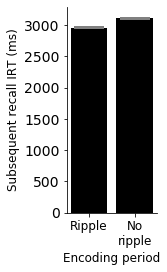

Model of 0 vs. ≥1 ripple (matches plot above)
                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        IRTs         
No. Observations:         41288          Method:                    REML         
No. Groups:               9              Scale:                     11371574.3191
Min. group size:          200            Likelihood:                -393989.6433 
Max. group size:          14147          Converged:                 Yes          
Mean group size:          4587.6                                                 
---------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------------------
Intercept                        3211.959  125.083 25.679 0.000 2966.800 3457.118
indicator[T.True]                -109.030   48.238 -2.260 0.024 -203.575  

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Full model (matches plot below)
                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      IRTs         
No. Observations:        41288        Method:                  REML         
No. Groups:              9            Scale:                   11371804.2933
Min. group size:         200          Likelihood:              -393990.6582 
Max. group size:         14147        Converged:               Yes          
Mean group size:         4587.6                                             
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   3494.930  164.240 21.279 0.000 3173.026 3816.833
ripple_rate                  -11.806   39.603 -0.298 0.766  -89.426   65.815
subject Var               565893.764   34.435                   

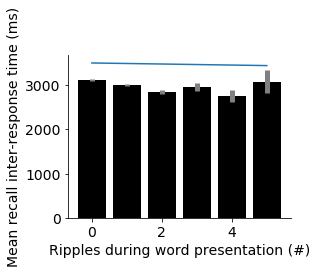

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64), array([23143, 11645,  4257,  1514,   483,   186,    38,    16,     4,
           2]))


In [59]:
from scipy.stats import ttest_ind,ttest_rel
import statsmodels.formula.api as smf

save_plot = 1

# plt.scatter(subsequent_IRT_time,encoding_ripple_number)
ripple_IRTs = np.array(subsequent_IRT_time)[np.array(encoding_ripple_number)>0]
nonripple_IRTs = np.array(subsequent_IRT_time)[np.array(encoding_ripple_number)==0]
np.mean(ripple_IRTs)
np.std(ripple_IRTs)/np.sqrt(len(ripple_IRTs))
np.mean(nonripple_IRTs)
np.std(nonripple_IRTs)/np.sqrt(len(nonripple_IRTs))

print(ttest_ind(ripple_IRTs,nonripple_IRTs))
mean_correct = [np.mean(ripple_IRTs),
                np.mean(nonripple_IRTs)]
ste_correct = [np.std(ripple_IRTs)/np.sqrt(len(ripple_IRTs)),
                np.std(nonripple_IRTs)/np.sqrt(len(nonripple_IRTs))]

# plot IRT errorbars

subplots(1,1, figsize=(2.5,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
# plot([-1,5],[0,0],color='k')
plot_color = (0,0,0)
errorbar_color = (0.5,0.5,0.5)
bar(range(2),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
ylabel('Subsequent recall IRT (ms)',size=12)
xticks([0,1],['Ripple','No\nripple'],fontsize=12)
xlabel('Encoding period',size=12)
tight_layout()

if save_plot == 1:
    if len(location_selected)>1:
        location_selected = location_selected[0]+location_selected[1]
    plt.savefig('../figures/IRTs/'+location_selected+'-'+sub_selection+'-ripple_IRTs.pdf',transparent=True); show()

# regression model

max_num_ripples = 5 # 6 and 7 ripples have 9 and 1 trial respectively

plot_df = pd.DataFrame({'IRTs':subsequent_IRT_time,
                        'indicator':np.array(encoding_ripple_number)>0,
                        'ripple_rate':encoding_ripple_number,
                        'session':IRT_sess,'subject':IRT_sess
                        })

# model of IRTs for 0 vs. ≥1 ripple
vc = {'session':'0+session'} # to nest sessions in subjects
rr_model = smf.mixedlm("IRTs~indicator",
                       plot_df, groups="subject", vc_formula=vc, re_formula="~indicator") 
rr_fit = rr_model.fit(reml=True,method='nm',maxiter=2000)
print('Model of 0 vs. ≥1 ripple (matches plot above)')
print(rr_fit.summary())
print(rr_fit.pvalues)

# model of bottom plot
vc = {'session':'0+session'} # to nest sessions in subjects
rr_model = smf.mixedlm("IRTs~ripple_rate",
                       plot_df, groups="subject", vc_formula=vc, re_formula="~ripple_rate") 
rr_fit2 = rr_model.fit(reml=True,method='nm',maxiter=2000)
print('Full model (matches plot below)')
print(rr_fit2.summary())


# plot something closer to model, which is IRTs conditional on ripple rate
mean_IRT_by_rate = []
SE_IRT_by_rate = []
for rate in np.unique(encoding_ripple_number):
    mean_IRT_by_rate.append( np.mean(np.array(subsequent_IRT_time)[encoding_ripple_number==rate]) )
    SE_IRT_by_rate.append( np.std(np.array(subsequent_IRT_time)[encoding_ripple_number==rate])/ \
                              np.sqrt(len(np.array(subsequent_IRT_time)[encoding_ripple_number==rate])) )
subplots(1,1, figsize=(4,3))

xr = range(max_num_ripples+1) # +1 to include 0 ripple bin
bar(xr,mean_IRT_by_rate[0:max_num_ripples+1],
    yerr=SE_IRT_by_rate[0:max_num_ripples+1],color=plot_color,error_kw=dict(lw=5, capsize=0, capthick=0, ecolor=errorbar_color))
plot(xr,rr_fit2.params.Intercept+rr_fit2.params.ripple_rate*xr)
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
ylabel('Mean recall inter-response time (ms)')
xlabel('Ripples during word presentation (#)'); show()
print(np.unique(encoding_ripple_number,return_counts=True))

a=1;

In [60]:
rr_fit.pvalues
rr_fit2.pvalues

Intercept                          2.027993e-145
indicator[T.True]                   2.380504e-02
subject Var                                  NaN
subject x indicator[T.True] Cov              NaN
indicator[T.True] Var               2.326410e-01
session Var                         5.050352e-02
dtype: float64

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Intercept                    1.759120e-100
ripple_rate                   7.656286e-01
subject Var                   1.097417e-06
subject x ripple_rate Cov     1.846019e-01
ripple_rate Var               4.205050e-01
session Var                            NaN
dtype: float64

5

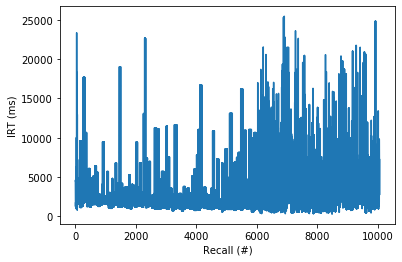

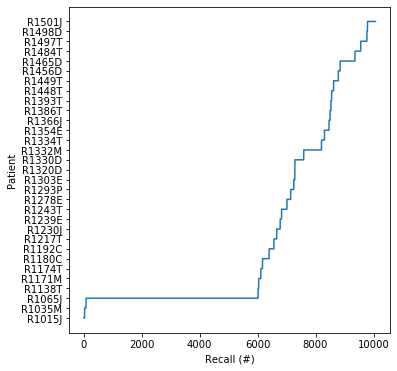

In [153]:
plot(subsequent_IRT_time); xlabel('Recall (#)'); ylabel('IRT (ms)'); show()
subplots(1,1,figsize=(5.75,6))
plot(IRT_sess); xlabel('Recall (#)'); ylabel('Patient'); show();

## IRTs vs. clustering

(array(['A', 'B', 'C', 'D', 'I', 'R'], dtype='<U1'), array([11891,  2007, 12969, 11557,  2371,   493]))
Overall mean for clustering type: 1850.920569501686 ± 27.242579371736277
Overall mean for clustering type: 2043.519634205884 ± 29.861016928034125
Overall mean for clustering type: 2727.617566054611 ± 38.16320463875227


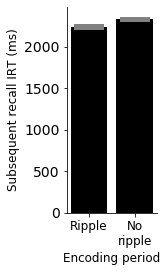

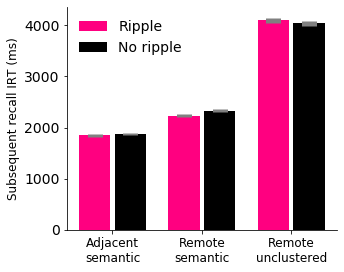

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


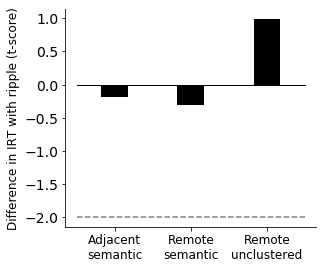

In [65]:
save_plot = 1

clustering_type = ['C'] # 'A', 'C', 'D' are adjacent semantic, remote semantic, and remote unclustered

ripple_IRTs = np.array(subsequent_IRT_time)[((np.array(encoding_ripple_number)>0)&([single_IRT in clustering_type for single_IRT in IRT_clustering]))]
nonripple_IRTs = np.array(subsequent_IRT_time)[((np.array(encoding_ripple_number)==0)&([single_IRT in clustering_type for single_IRT in IRT_clustering]))]

mean_correct = [np.mean(ripple_IRTs),
                np.mean(nonripple_IRTs)]
ste_correct = [np.std(ripple_IRTs)/np.sqrt(len(ripple_IRTs)),
                np.std(nonripple_IRTs)/np.sqrt(len(nonripple_IRTs))]

# plot IRT errorbars

subplots(1,1, figsize=(2.5,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
# plot([-1,5],[0,0],color='k')
plot_color = (0,0,0)
errorbar_color = (0.5,0.5,0.5)
bar(range(2),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
ylabel('Subsequent recall IRT (ms)',size=12)
xticks([0,1],['Ripple','No\nripple'],fontsize=12)
xlabel('Encoding period',size=12)
print(np.unique(IRT_clustering,return_counts=True))
tight_layout()

# # for stats try a paired t-test by patient
# sub_ripple_IRTs = []
# sub_nonripple_IRTs = []
# min_trials = 5 # min trials per subject for both ripple and nonripple for paired t-test
# for sub in np.unique(IRT_sub):
#     sub_clust_selection = ([single_IRT in clustering_type for single_IRT in IRT_clustering])&(np.array(IRT_sub)==sub)
#     if (sum((np.array(encoding_ripple_number)>0) & sub_clust_selection)>=min_trials) & \
#         (sum((np.array(encoding_ripple_number)==0) & sub_clust_selection)>=min_trials):
        
#         sub_ripple_IRTs.append(np.mean(np.array(subsequent_IRT_time)
#                            [((np.array(encoding_ripple_number)>0) & sub_clust_selection)]
#                                   ))
#         sub_nonripple_IRTs.append(np.mean(np.array(subsequent_IRT_time)
#                            [((np.array(encoding_ripple_number)==0) & sub_clust_selection)]
#                                      ))
# print(ttest_rel(sub_ripple_IRTs,sub_nonripple_IRTs))


# plot all the clustering trial types in one for ripple vs. no ripple

temp_means = []
temp_ste = []
temp_means2 = []
temp_ste2 = []

clustering_types = ['A','C','D'] #,'I']
for ct in clustering_types:
    ripple_IRTs = np.array(subsequent_IRT_time)[((np.array(encoding_ripple_number)>0)&(np.array(IRT_clustering)==ct))]
    nonripple_IRTs = np.array(subsequent_IRT_time)[((np.array(encoding_ripple_number)==0)&(np.array(IRT_clustering)==ct))]
    
    temp_means.append(np.mean(ripple_IRTs))
    temp_ste.append(np.std(ripple_IRTs)/np.sqrt(len(ripple_IRTs)))
    temp_means2.append(np.mean(nonripple_IRTs))
    temp_ste2.append(np.std(nonripple_IRTs)/np.sqrt(len(nonripple_IRTs)))    
    print('Overall mean for clustering type: '+str(np.mean(temp_means))+' ± '+str(np.mean(temp_ste)))
    
fig,ax = plt.subplots(1,1, figsize=(5,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
# plot([-1,5],[0,0],color='k')
plot_color_pink = (1,0,0.5)
plot_color_black = (0,0,0)
errorbar_color = (0.5,0.5,0.5)
width = 0.35
rects1 = ax.bar(np.arange(len(clustering_types))-0.2,temp_means,yerr=temp_ste,
                width=width,color=plot_color_pink,error_kw=dict(lw=15, capsize=0, capthick=0, ecolor=errorbar_color),label='Ripple')
rects2 = ax.bar(np.arange(len(clustering_types))+0.2,temp_means2,yerr=temp_ste2,
                width=width, color=plot_color_black,error_kw=dict(lw=15, capsize=0, capthick=0, ecolor=errorbar_color),label='No ripple')
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
ylabel('Subsequent recall IRT (ms)',size=12)
xticks(range(len(clustering_types)),['Adjacent\nsemantic','Remote\nsemantic','Remote\nunclustered'],fontsize=12)
ax.legend(frameon=False)
tight_layout()
if save_plot == 1:
    plt.savefig('../figures/IRTs/'+location_selected+'-'+sub_selection+'-ripple_CLUSTERING_IRTs.pdf',transparent=True); 
show()

# same but do t-scores of ME model instead

clustering_types = ['A','C','D']
clust_t_scores = []
for ct in clustering_types:
    selected_cts = np.array(IRT_clustering)==ct
    clust_df = pd.DataFrame({'IRTs':np.array(subsequent_IRT_time)[selected_cts],
                        'ripple_indicator':(np.array(encoding_ripple_number)>0)[selected_cts],
                        'session':np.array(IRT_sess)[selected_cts],
                        'subject':np.array(IRT_sess)[selected_cts]
                        })

    vc = {'session':'0+session'} # to nest sessions in subjects
    rr_model = smf.mixedlm("IRTs~ripple_indicator",
                           clust_df, groups="subject", vc_formula=vc, re_formula="~ripple_indicator") 
    rr_fit = rr_model.fit(reml=True,method='nm',maxiter=2000)
    clust_t_scores.append(rr_fit.tvalues[1])
    
fig,ax = plt.subplots(1,1, figsize=(4.5,4))    
ax.bar(np.arange(len(clustering_types)),clust_t_scores,
                width=width,color=plot_color_black,error_kw=dict(lw=15, capsize=0, capthick=0, ecolor=errorbar_color))
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
ylabel('Difference in IRT with ripple (t-score)',size=12)
xticks(range(len(clustering_types)),['Adjacent\nsemantic','Remote\nsemantic','Remote\nunclustered'],fontsize=12)
xrr = np.arange(-0.5,3.5)
plot(xrr,np.zeros(len(xrr)),'-',color=(0,0,0),Linewidth=1)
plot(xrr,-2*np.ones(len(xrr)),'--',color=(0.5,0.5,0.5))
# ylim(-3.5,0.5)
    
a=1;

# David wants encoding ripple df 2022-07-05

In [235]:
# find adjacent semantic or remote semantic with ripples

# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

# these values are all for subject-level SCE v. avg_recalls analysis
# min_SCE_trials = 10 # minimum SCE trials in session to include in SCE v. avg_recalls plot

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors
sr_factor = 2 # downsampled ripples to 500 Hz.
PRE_start_end = range(-1100,-100)

stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding 
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
# comes to 400:1200 for 100 to 1700 of 1500 len timeseries


temp_corr = []
temp_RR = []
temp_sess = []
temp_sub = []
temp_word = []
temp_sem_key = []
temp_lists = []
temp_cat = []
temp_sp = []
temp_elec = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess]) 
    
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs][:,encoding_range]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            list_ch_words = session_events.item_name[list_ch_idxs].values
            
            for word in range(sum(list_ch_idxs)): 

                if (word+1) in list_ch_recall_positions[0]: # serial positions are 1-indexed so add 1 to check in list_ch_recall_positions
                    temp_corr.append(1)
                    # use index from serialpos to get clustering classification
                    if ((sess== 'R1108J-2')&(ln==25)): # single mistake shwos up
                        if word == 8:
                            temp_sem_key.append('A')
                        elif word == 9:
                            temp_sem_key.append('Z')
                    else: 
                        temp_sem_key.append(list_ch_semantic_key[0][list_ch_recall_positions[0].index(word+1)])
                else:
                    temp_corr.append(0)
                    temp_sem_key.append('')
                temp_RR.append(sum(list_ch_encoding_array[word,:])/1.6)
                temp_sess.append(sess)
                temp_sub.append(sess[0:6])
                temp_word.append(list_ch_words[word])
                temp_sp.append(word)
                temp_cat.append(list_ch_cats[word])
                temp_lists.append(ln)
                temp_elec.append(elec)
                
a=1;

In [236]:
len(temp_corr)
len(temp_RR)
len(temp_sess)
len(temp_sub)
len(temp_word)
len(temp_sem_key)
len(temp_cat)
encoding_ripple_df = pd.DataFrame(data={'session':temp_sess,'subject':temp_sub,'serialpos':temp_sp,
                                            'semantic_clustering_key':temp_sem_key,'words':temp_word,
                                            'word_correct':temp_corr,'ripple_rate':temp_RR,
                                            'category':temp_cat,'list':temp_lists,'channel':temp_elec})
encoding_ripple_df.to_csv('/home1/john/SWR/compiled/'+location_selected+'_encoding_ripple_df.csv',index=False)
encoding_ripple_df

55104

55104

55104

55104

55104

55104

55104

,session,subject,serialpos,semantic_clustering_key,words,word_correct,ripple_rate,category,list,channel
0,R1004D-0,R1004D,0,,DESK,0,0.000,Furniture,1,LOTD3-LOTD4
1,R1004D-0,R1004D,1,,TABLE,0,0.000,Furniture,1,LOTD3-LOTD4
2,R1004D-0,R1004D,2,,CARROT,0,0.000,Vegetables,1,LOTD3-LOTD4
3,R1004D-0,R1004D,3,,CUCUMBER,0,0.625,Vegetables,1,LOTD3-LOTD4
4,R1004D-0,R1004D,4,,HAWK,0,0.000,Birds,1,LOTD3-LOTD4
...,...,...,...,...,...,...,...,...,...,...
55099,R1525J-6,R1525J,7,,TRUMPET,0,0.000,Instruments,12,LD3-LD4
55100,R1525J-6,R1525J,8,C,ORANGUTAN,1,0.000,Zoo,12,LD3-LD4
55101,R1525J-6,R1525J,9,,BEAR,0,0.000,Zoo,12,LD3-LD4
55102,R1525J-6,R1525J,10,,CARDINAL,0,1.875,Birds,12,LD3-LD4
